## Описание проекта

### Вводная

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

### Задача

Первая задача — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.  

Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

### Инструкция по выполнению

Первая задача - обучите как минимум две модели.  
Возьмите одну линейную модель, а в качестве второй — дерево решений.  
Подберите гиперпараметры как минимум для одной модели с помощью одного из известных вам инструментов.  
Выберите лучшую модель и проверьте её качество.  
Выбор делайте на основе новой метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»).  
Критерий успеха: SMAPE ≤15 на тестовой выборке.

Вторая задача - обучите как минимум три модели.  
Как минимум для двух из них подберите гиперпараметры.  
Проверьте качество лучшей модели.  
Метрика оценки качества в этой задаче — ROC-AUC.  
Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке.  

## Подготовка к работе

In [1]:
# функция для кнопки скрытия кода
from IPython.display import (
    display,
    HTML
)

def create_toggle_code_button(button_text="Переключить видимость"):
    toggle_code_str = f'''
    <form action="javascript:code_toggle()">
        <input type="submit" id="toggleButton" value="{button_text}">
    </form>
    '''

    toggle_code_prepare_str = '''
    <script>
    function code_toggle() {
        $('div.cell.code_cell.rendered.selected div.input').toggle();
    }
    </script>
    '''

    display(HTML(toggle_code_prepare_str + toggle_code_str))

create_toggle_code_button("Функция спойлера")

In [2]:
%%time
# здесь будем ставить все, чего нам не хватает
!pip install missingno -q
!pip install optuna -q
!pip install optuna-integration[sklearn] -q
!pip install shap -q
!pip install phik -q
!pip install --upgrade scikit-learn -q
# !pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn -U -q
# !pip install scikit-learn==1.1.3 -q
!pip install tdqm -q
!pip install imbalanced-learn -q

create_toggle_code_button("Установка и обновление библиотек")

CPU times: total: 46.9 ms
Wall time: 5.05 s


In [3]:
# а здесь импортировать все для работы
import warnings

import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import sklearn
import optuna
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno

from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import (
    LogisticRegression,
    LinearRegression,
    Ridge
)

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    make_scorer
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.exceptions import ConvergenceWarning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import (
    Pipeline,
    FeatureUnion
)
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder,
    PolynomialFeatures,
    FunctionTransformer
)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from optuna.integration import OptunaSearchCV
from optuna.distributions import (
    IntDistribution,
    FloatDistribution,
    CategoricalDistribution
)
from phik import phik_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from plotly.subplots import make_subplots
from tqdm import tqdm
from joblib import parallel_backend
from imblearn.over_sampling import SMOTE
from scipy import stats

create_toggle_code_button("Импорты")

In [4]:
# здесь и дальше подготовим функции которые пригодятся в дальнейшем
# все в одной ячейке - потому что надоело по одной копипастить из проекта в проект....

# 1. Настройка окружения
# sns.set()  # Устанавливает стиль визуализации для графиков Seaborn
# pd.set_option()  # Настраивает формат отображения чисел в DataFrame
# warnings.simplefilter()  # Игнорирует предупреждения определенного типа

# 2. Функции для предварительной обработки данных
# missing_data(data) - Оценивает и отображает количество пропущенных значений в DataFrame
# drop_duplicated(data) - Проверяет и удаляет дубликаты в DataFrame
# check_data(data) - Выполняет проверку и очистку данных, включая пропуски и дубликаты
# process_spaces(s) - Удаляет лишние пробелы в строке
# replace_spaces(s) - Заменяет пробелы на нижние подчеркивания в строке

# 3. Анализ данных
# check_unique_cat(data) - Проверяет уникальные значения в категориальных столбцах
# check_numeric_columns(data) - Возвращает список количественных столбцов в DataFrame
# get_ohe_columns(data) - Возвращает бинарные категориальные столбцы (с 2 уникальными значениями)
# get_ord_columns(data) - Возвращает категориальные столбцы (с более чем 2 уникальными значениями)
# get_num_columns(data) - Возвращает количественные столбцы

# 4. Визуализация данных
# plot_numerical_columns(data) - Строит боксплоты для количественных столбцов
# plot_numerical_columns_hist(data, target_column) - Строит гистограммы для количественных столбцов
# plot_combined(data, col=None, target=None, col_type=None, legend_loc='best') - Строит комбинированные графики (гистограммы и боксплоты) для количественных столбцов
# plot_density_heatmap(data, x, y) - Строит тепловую карту плотности для двух переменных
# plot_scatter_with_categories(data) - Строит диаграммы рассеяния с разбивкой по категориальным данным
# plot_categorical_columns(data, col, target) - Визуализирует категориальные данные с возможностью группировки по целевому столбцу

# 5. Статистический анализ
# get_vif(data, drop_col, target_col) - Вычисляет VIF для признаков в данных
# smape(y_true, y_pred) - Вычисляет SMAPE (симметричное среднее абсолютное процентное отклонение)

# 6. Объединение данных
# merge_base(bases, index, merge_type) - Объединяет список DataFrame по заданному индексу и типу объединения


create_toggle_code_button("Описание функций")


In [5]:
# это даст нам красивые выводы
sns.set()
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.simplefilter(action='ignore', category=FutureWarning)

# форматирования текста
def format_display(text):
    return HTML(f"<span style='font-size: 1.5em; font-weight: bold; font-style: italic;'>{text}</span>")

# сделаем функцию оценки пропусков в датасетах
def missing_data(data):
    missing_data = data.isna().sum()
    missing_data = missing_data[missing_data > 0]
    display(missing_data)
    
# функция для обработки пробелов
def process_spaces(s):
    if isinstance(s, str):
        s = s.strip()
        s = ' '.join(s.split())
    return s

# замена пробелов на нижнее подчеркинвание в названии столбцов
def replace_spaces(s):
    if isinstance(s, str):
        s = s.strip()
        s = '_'.join(s.split())
    return s

def drop_duplicated(data):
    # проверка дубликатов
    display(format_display("Проверим дубликаты и удалим, если есть"))
    num_duplicates = data.duplicated().sum()
    display(num_duplicates)
    
    if num_duplicates > 0:
        display("Удаляем")
        data = data.drop_duplicates(keep='first').reset_index(drop=True)  # обновляем DataFrame
    else:
        display("Дубликаты отсутствуют")
    return data

def check_data(data):
    # приведем все к нижнему регистру
    data.columns = data.columns.str.lower()
    
    # удалим лишние пробелы в строках
    data = data.applymap(process_spaces)

    # и в названии столбцов
    data.columns = [replace_spaces(col) for col in data.columns]
    
    # общая информация 
    display(format_display("Общая информация базы данных"))
    display(data.info())
    
    # 5 строк
    display(format_display("5 случайных строк"))
    display(data.sample(5))
    
    # пропуски
    display(format_display("Число пропусков в базе данных"))
    display(missing_data(data))

    # проверка на наличие пропусков
    if data.isnull().sum().sum() > 0:
        display(format_display("Визуализация пропусков"))
        msno.bar(data)
        plt.show()
        
    # средние характеристики
    display(format_display("Характеристики базы данных"))
    display(data.describe().T)
    
    data = drop_duplicated(data)
    
    return data  # возвращаем измененные данные

def check_unique_cat(data):
    text_columns = data.select_dtypes(include=['object'])
    
    if text_columns.empty:
        display("В DataFrame нет столбцов с данными типа 'object'.")
        return
    
    unique_values = {col: text_columns[col].unique() for col in text_columns.columns}
    for col, values in unique_values.items():
        display(f"Уникальные значения в столбце '{col}': {values}")
        
def check_numeric_columns(data):
    numeric_columns = data.select_dtypes(include=['int64', 'float64'])
    
    if numeric_columns.empty:
        return []
    else:
        return numeric_columns.columns.tolist()
    
# боксплот - только столбцы типа int и float
def plot_numerical_columns(data):
    numerical_columns = data.select_dtypes(include=['int', 'float']).columns.tolist()
    
    n = len(numerical_columns)
    ncols = 3
    nrows = (n + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5 * nrows))
    axs = axs.flatten()

    for i, col in enumerate(numerical_columns):
        axs[i].boxplot(data[col].dropna())
        axs[i].set_title(col)
        axs[i].set_ylabel('Значения')
        axs[i].set_xticklabels([''])

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()
    
def plot_numerical_columns_hist(data, target_column=None):
    numerical_columns = data.select_dtypes(include=['int', 'float']).columns.tolist()
    num_cols = len(numerical_columns)
    
    ncols = 2
    nrows = int(np.ceil(num_cols / ncols))

    f, axes = plt.subplots(nrows, ncols, figsize=(16, nrows * 4))
    axes = axes.flatten()

    for i, col in enumerate(numerical_columns):
        # Гистограмма
        axes[i].set_title(f'Распределение признака {col}', fontsize=16)
        axes[i].set_ylabel('Количество', fontsize=14)

        if target_column and target_column in data.columns:
            sns.histplot(data=data, x=col, bins=20, kde=True, ax=axes[i], hue=target_column, multiple="stack")
        else:
            sns.histplot(data=data, x=col, bins=20, kde=True, ax=axes[i])

    for j in range(i + 1, nrows * ncols):
        f.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    
def plot_combined(data, col=None, target=None, col_type=None, legend_loc='best'):
    """
    Строит графики для числовых столбцов в DataFrame, автоматически определяя их типы (дискретные или непрерывные).

    :param data: DataFrame, содержащий данные для визуализации.
    :param col: Список столбцов для построения графиков. Если None, будут использованы все числовые столбцы.
    :param target: Столбец, по которому будет производиться разделение (для hue в графиках).
    :param col_type: Словарь, определяющий типы столбцов ('col' для непрерывных и 'dis' для дискретных).
                     Если None, типы будут определены автоматически.
    :param legend_loc: Положение легенды для графиков (по умолчанию 'best').
    :return: None. Графики отображаются с помощью plt.show().
    """
    
    # Определяем числовые столбцы
    if col is None:
        numerical_columns = data.select_dtypes(include=['int', 'float']).columns.tolist()
    else:
        numerical_columns = col

    # Если col_type не указан, определяем типы автоматически
    if col_type is None:
        col_type = {}
        for col in numerical_columns:
            unique_count = data[col].nunique()
            if unique_count > 20:
                col_type[col] = 'col'  # Непрерывные данные
            else:
                col_type[col] = 'dis'  # Дискретные данные

    total_plots = len(numerical_columns) * 2
    ncols = 2
    nrows = (total_plots + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
    axs = axs.flatten()

    index = 0

    for col in numerical_columns:
        # Определяем тип графика
        plot_type = col_type.get(col)
        if plot_type is None:
            raise ValueError(f"Тип для столбца '{col}' не указан в col_type.")

        # Гистограмма или countplot
        if index < len(axs):
            if plot_type == 'col':
                if target is not None:
                    sns.histplot(data, x=col, hue=target, bins=20, kde=True, ax=axs[index])
                    handles, labels = axs[index].get_legend_handles_labels()
                    if handles:
                        axs[index].legend(title=target, loc=legend_loc)
                else:
                    sns.histplot(data[col].dropna(), bins=20, kde=True, ax=axs[index])
                axs[index].set_title(f'Гистограмма: {col}')
            elif plot_type == 'dis':
                if target is not None:
                    sns.countplot(data=data, x=col, hue=target, ax=axs[index])
                    handles, labels = axs[index].get_legend_handles_labels()
                    if handles:
                        axs[index].legend(title=target, loc=legend_loc)
                else:
                    sns.countplot(data=data, x=col, ax=axs[index])
                axs[index].set_title(f'Countplot: {col}')
            index += 1

        # Боксплот
        if index < len(axs):
            sns.boxplot(x=data[col], ax=axs[index])
            axs[index].set_title(f'Боксплот: {col}')
            index += 1

    # Отключаем оставшиеся оси
    for j in range(index, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

    
def get_ohe_columns(data):
    # выбор бинарных признаков (категориальные с 2 уникальными значениями)
    return data.select_dtypes(include=['object']).nunique()[data.select_dtypes(include=['object']).nunique() == 2].index.tolist()

def get_ord_columns(data):
    # выбор категориальных признаков (с более чем 2 уникальными значениями)
    return data.select_dtypes(include=['object']).nunique()[data.select_dtypes(include=['object']).nunique() > 2].index.tolist()

def get_num_columns(data):
    # используем уже созданную функцию для получения количественных признаков
    return check_numeric_columns(data)

def histogram(data, col, target):
    plt.figure(figsize=(8,6))
    plot = sns.histplot(data, bins=20, kde=True, hue=target, x=col)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_ylabel('Количество', fontsize=14)
    
def plot_density_heatmap(data, x, y):
    fig = px.density_heatmap(data, x=x, y=y, nbinsx=50, nbinsy=50, color_continuous_scale='Greens')
    fig.update_layout(title=f'Зависимость {x} от {y}',
                      xaxis_title=x,
                      yaxis_title=y,
                      width=600,
                      height=500)
    fig.show()
    
class ReplaceEmptyWithNaN(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.where((X == '') | (X.isnull()), np.nan, X)

    def get_feature_names_out(self, input_features=None):
        return input_features
    
def merge_base(bases, index, merge_type):
    """
    Объединяет список таблиц по заданному индексу.

    :param bases: Список таблиц (DataFrame), которые нужно объединить.
    :param index: Имя столбца, по которому будет происходить объединение.
    :param merge_type: Тип объединения ('inner', 'outer', 'left', 'right').
    :return: Объединённая таблица.
    """
    merged_df = bases[0]
    for base in bases[1:]:
        merged_df = pd.merge(merged_df, base, on=index, how=merge_type)

    return merged_df

def plot_scatter_with_categories(data):
    """
    Функция для построения диаграмм рассеяния с разбивкой по категориальным данным.
    
    :param data: DataFrame с данными.
    """
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()
    
    for column in categorical_columns:
        plt.figure(figsize=(15, 10))
        sns.scatterplot(data=data, x='quit', y='satisfaction_predictions', hue=column, alpha=0.7)
        plt.xlabel('Вероятность увольнения')
        plt.ylabel('Удовлетворенность')
        plt.title(f'Зависимость вероятности увольнения от удовлетворенности {column}')
        plt.legend(title=column)
        plt.show()
        
def plot_categorical_columns(data, col=None, target=None):
    """
    Функция для визуализации категориальных данных с возможностью группировки по целевому столбцу.
    
    :param data: DataFrame с категориальными данными
    :param col: Название столбца для визуализации (по умолчанию None — визуализируются все категориальные столбцы)
    :param target: Название столбца для группировки данных (по умолчанию None — без группировки)
    :return: None — функция отображает графики
    """
    categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
    
    if col is not None and col in categorical_columns:
        categorical_columns = [col]
    elif col is not None:
        print(f"Столбец '{col}' не найден в данных.")
        return

    n = len(categorical_columns)
    ncols = 2
    nrows = (n * 2 + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6 * nrows))
    axs = axs.flatten()

    index = 0
    colors = plt.cm.tab10.colors

    for col in categorical_columns:
        unique_values = data[col].value_counts().index
        color_map = {value: colors[i] for i, value in enumerate(unique_values)}

        # Визуализация круговой диаграммы
        grouped_data = data[col].value_counts()
        axs[index].pie(grouped_data, labels=grouped_data.index, autopct='%1.1f%%', startangle=90, colors=[color_map[val] for val in grouped_data.index])
        axs[index].set_title(f'{col} (общая)')
        axs[index].set_ylabel('')
        index += 1

        # Визуализация гистограммы
        if target is not None and target in data.columns:
            # Создаем MultiIndex для unstack
            grouped_data = data.groupby([target, col]).size().unstack(fill_value=0)
            grouped_data.plot(kind='bar', ax=axs[index], color=[color_map[val] for val in grouped_data.columns])
        else:
            data[col].value_counts().plot(kind='bar', ax=axs[index], color=[color_map[val] for val in data[col].value_counts().index])

        axs[index].set_title(f'{col} (гистограмма)')
        axs[index].set_ylabel('Частота')
        index += 1

    for j in range(index, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()
    
def get_vif(data, drop_col, target_col):
    """
    Вычисляет VIF для признаков в данных.

    Параметры:
    data: DataFrame с исходными данными.
    drop_col: Название столбца, который нужно исключить.
    target_col: Название целевого столбца, который нужно исключить.

    Возвращает:
    DataFrame с признаками и их VIF.
    """
    # Подготовка данных
    X_test = data.drop(columns=[drop_col, target_col])

    # Кодирование категориальных признаков
    le = LabelEncoder()
    for col in X_test.select_dtypes(include=['object']).columns:
        X_test[col] = le.fit_transform(X_test[col])

    # Добавление константы
    X_test = X_test.assign(const=1)

    # Вычисление VIF
    vif_data = pd.DataFrame()
    vif_data["Признаки"] = X_test.columns
    vif_data["VIF"] = [variance_inflation_factor(X_test.values, i) for i in range(X_test.shape[1])]

    # Удаление константы из результатов
    vif_data = vif_data[vif_data["Признаки"] != "const"]

    return vif_data

def smape(y_true, y_pred):
    """
    Вычисляет SMAPE (симметричное среднее абсолютное процентное отклонение).
    
    :param y_true: Фактические значения (numpy array или pandas Series)
    :param y_pred: Предсказанные значения (numpy array или pandas Series)
    :return: Значение SMAPE
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0  # Избегаем деления на ноль
    
    return 100 * np.mean(diff)

def analyze_data(dataframes, drop_columns):
    """
    Анализирует данные, удаляет указанные столбцы и строит графики распределения
    для общих числовых столбцов.

    :param dataframes: Список баз данных (списки pandas DataFrame)
    :param drop_columns: Список столбцов для удаления (список строк)
    """

    cleaned_data = [df.drop(columns=drop_columns, errors='ignore') for df in dataframes]
    
    # Находим общие числовые столбцы
    common_columns = set(cleaned_data[0].select_dtypes(include=['float64', 'int64']).columns)
    for df in cleaned_data[1:]:
        common_columns.intersection_update(df.select_dtypes(include=['float64', 'int64']).columns)

    if not common_columns:
        print("Нет общих числовых столбцов для анализа.")
        return

    # Преобразуем множество в список
    common_columns = list(common_columns)

    combined_data = pd.concat(
        [df[common_columns].assign(dataset=f'base_{i+1}') for i, df in enumerate(cleaned_data)],
        keys=[f'base_{i+1}' for i in range(len(cleaned_data))],
        names=['dataset', 'index']
    )

    palette = {f'base_{i+1}': 'blue' if i == 0 else 'orange' for i in range(len(cleaned_data))}
    
    for column in common_columns:
        plt.figure(figsize=(10, 6))
        sns.kdeplot(data=combined_data, x=column, hue='dataset', common_norm=False, fill=True, palette=palette)
        plt.title(f'Распределение {column}')
        plt.xlabel(column)
        plt.ylabel('Плотность')
        
        handles, labels = plt.gca().get_legend_handles_labels()
        if handles:
            plt.legend(title='Набор данных', loc='best', labels=[f'Таблица {label}' for label in labels])
        
        plt.show()

# Пример использования
# analyze_data([train_data, features_test_data], ['id'])
    
def calculate_phik_correlations(dataframes, target_column, drop_columns=None):
    """
    Вычисляет корреляцию признаков с целевым значением с использованием phik
    для нескольких баз данных и возвращает DataFrame с корреляциями.

    :param dataframes: Список pandas DataFrame с данными
    :param target_column: Название целевого столбца
    :param drop_columns: Список столбцов для исключения из анализа
    :return: DataFrame с корреляциями по базам
    """
    combined_corr = pd.DataFrame()

    for i, df in enumerate(dataframes):
        if drop_columns:
            df = df.drop(columns=drop_columns, errors='ignore')

        phik_corr = df.phik_matrix()

        for feature in phik_corr.index:
            if feature != target_column:
                combined_corr.loc[feature, f'base_{i+1}'] = phik_corr.loc[feature, target_column]

    combined_corr.index.name = 'Feature'
    
    return combined_corr
    
create_toggle_code_button("Функции")

In [6]:
# функции для этого проекта
def get_target_bin(base, col, num):
    """
    Функция для сегментации данных на основе заданного столбца и целевого числа.
    
    :param base: DataFrame
    :param col: Название столбца для сегментации
    :param num: Целевое число для сегментации
    :return: Обновленный DataFrame
    """
    updated_dfs = []
    
    for df in base:
        if col in df.columns:
            df['job_satisfaction_rate_bin'] = df[col].apply(lambda x: 'доволен' if x > num else 'недоволен')
        
        updated_dfs.append(df)
    
    return updated_dfs

create_toggle_code_button("Функции этого проекта")

In [7]:
# зафиксируем константы для последующего обучения
RANDOM_STATE = 20
TEST_SIZE = 0.1
CLASS_WEIGHT = 'balanced'
WEIGHTS_FOR_KNEIGHBORS = 'distance'
N = 15 # число испытаний для оптуны

## Загрузка данных

### Загрузка данных

Данные для первой задачи

In [8]:
# таблица, которая содержит тренировочные данные
train_data = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')

id — уникальный идентификатор сотрудника;  
dept — отдел, в котором работает сотрудник;  
level — уровень занимаемой должности;  
workload — уровень загруженности сотрудника;  
employment_years — длительность работы в компании (в годах);  
last_year_promo — показывает, было ли повышение за последний год;  
last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;  
supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;  
salary — ежемесячная зарплата сотрудника;  
job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.  

In [9]:
# таблица, которая содержит входные признаки тестовой выборки
features_test_data = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')

In [10]:
# таблица, которая содержит целевой признак тестовой выборки
test_target_data = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

Данные для второй задачи

In [11]:
# таблица, которая содержит тренировочные данные с увольнениями
train_data_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')

In [12]:
# таблица, которая содержит целевой признак тестовой выборки по увольнениями
test_target_quit_data = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

### train_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

id        dept   level workload  employment_years last_year_promo  \
658   314377       sales  junior   medium                 1              no   
890   958917       sales  junior     high                 2              no   
859   568025       sales  junior      low                 1              no   
3593  982458  purchasing  middle      low                 3              no   
3562  836519  purchasing  middle      low                 5              no   

     last_year_violations  supervisor_evaluation  salary  \
658                    no                      5   25200   
890                    no                      3   33600   
859                    no                      5   18000   
3593                   no                      4   30000   
3562                   no                      1   22800   

      job_satisfaction_rate  
658                    0.63  
890                    0.71  
859                    0.59  
3593                   0.64  
3562                   0.29

dept     6
level    4
dtype: int64

None

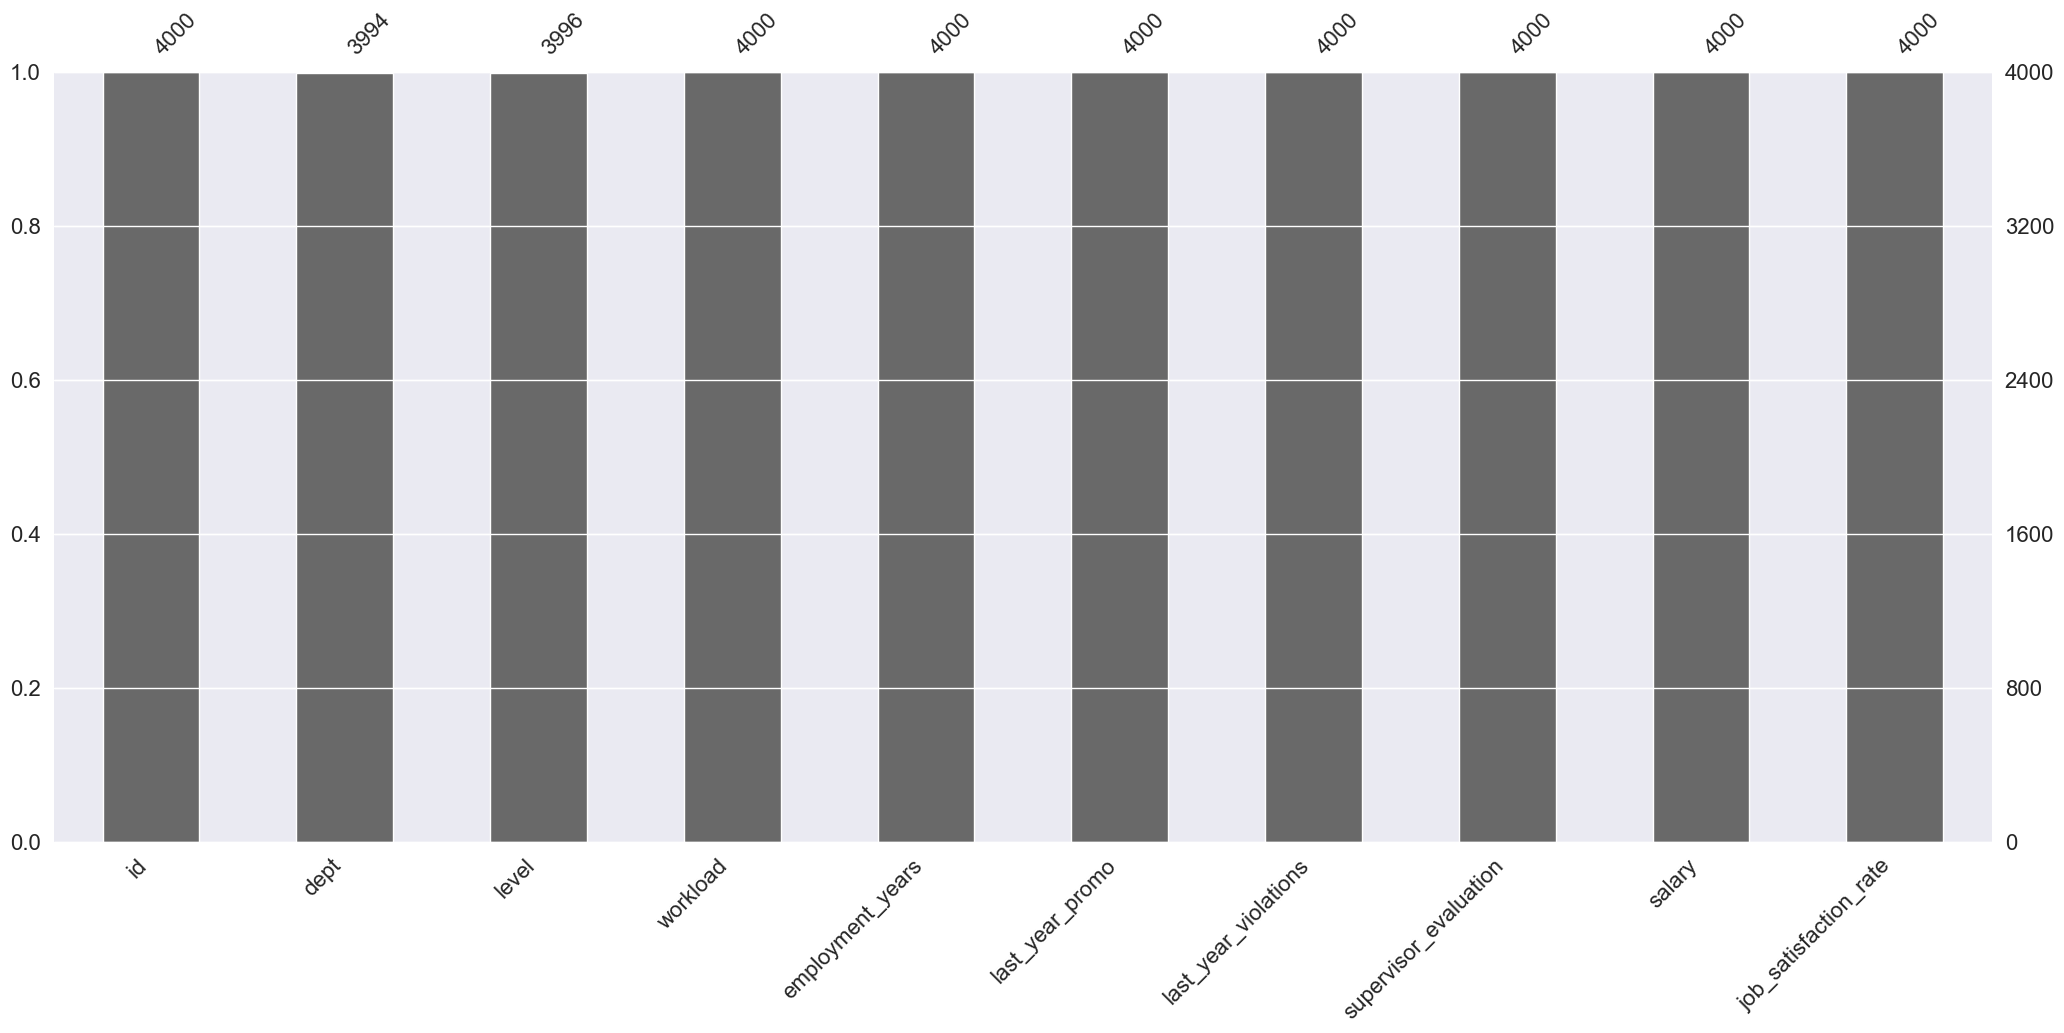

count      mean       std       min       25%  \
id                    4000.00 544957.62 257883.10 100954.00 322836.75   
employment_years      4000.00      3.72      2.54      1.00      2.00   
supervisor_evaluation 4000.00      3.48      1.01      1.00      3.00   
salary                4000.00  33926.70  14900.70  12000.00  22800.00   
job_satisfaction_rate 4000.00      0.53      0.23      0.03      0.36   

                            50%       75%       max  
id                    534082.50 771446.00 999521.00  
employment_years           3.00      6.00     10.00  
supervisor_evaluation      4.00      4.00      5.00  
salary                 30000.00  43200.00  98400.00  
job_satisfaction_rate      0.56      0.71      1.00

0

'Дубликаты отсутствуют'

In [13]:
# посмотрим, что у нас в каждом файле имеется
# обработкой, доработкой и преобразованиями займемся позже
train_data = check_data(train_data)

#### Выводы

Типы данных соответствуют тому, что в таблице.  
Есть пропуски - по ТЗ из надо обработать через pipeline, поэтому здесь пропускаем.  
Распределение значений в таблице нормальное - выбросов и аномалий, на первый взгляд, не наблюдается.  

### features_test_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

id        dept   level workload  employment_years last_year_promo  \
798   145247   marketing  middle   medium                 1              no   
1941  957645   marketing  junior   medium                 1              no   
1850  991581       sales  middle     high                 4              no   
1022  140278   marketing  middle      low                 6              no   
611   295847  technology  middle     high                 6              no   

     last_year_violations  supervisor_evaluation  salary  
798                    no                      4   40800  
1941                   no                      3   27600  
1850                  yes                      4   57600  
1022                  yes                      3   19200  
611                    no                      3   67200

dept     2
level    1
dtype: int64

None

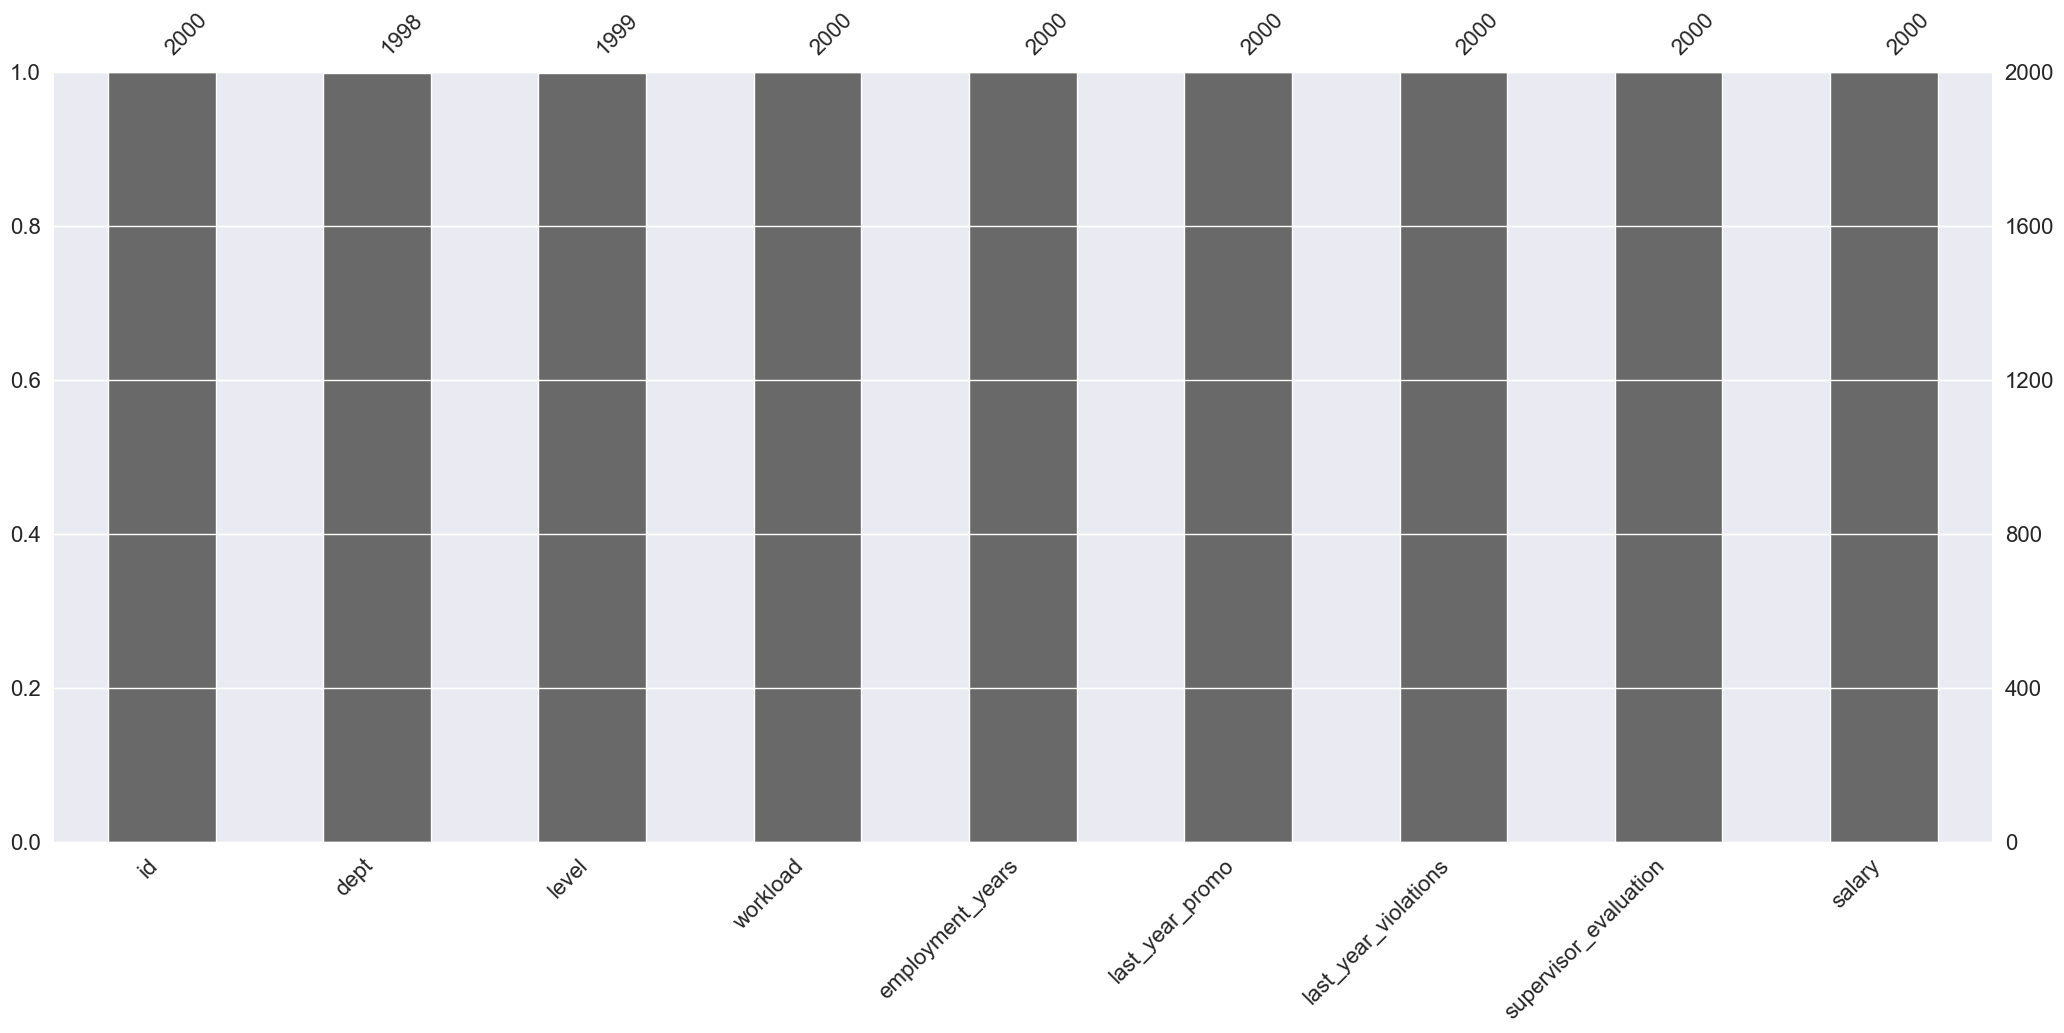

count      mean       std       min       25%  \
id                    2000.00 552765.21 253851.33 100298.00 339052.00   
employment_years      2000.00      3.67      2.54      1.00      1.00   
supervisor_evaluation 2000.00      3.53      1.00      1.00      3.00   
salary                2000.00  34066.80  15398.44  12000.00  22800.00   

                            50%       75%       max  
id                    550793.00 765763.75 999029.00  
employment_years           3.00      6.00     10.00  
supervisor_evaluation      4.00      4.00      5.00  
salary                 30000.00  43200.00  96000.00

0

'Дубликаты отсутствуют'

In [14]:
features_test_data = check_data(features_test_data)

#### Выводы

Все похоже на тренировочные данные - продолжим.

### test_target_data

In [15]:
test_target_data = check_data(test_target_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

id  job_satisfaction_rate
1611  982787                   0.75
401   519229                   0.43
1478  767764                   0.68
1536  611266                   0.42
1353  547525                   0.78

Series([], dtype: int64)

None

count      mean       std       min       25%  \
id                    2000.00 552765.21 253851.33 100298.00 339052.00   
job_satisfaction_rate 2000.00      0.55      0.22      0.03      0.38   

                            50%       75%       max  
id                    550793.00 765763.75 999029.00  
job_satisfaction_rate      0.58      0.72      1.00

0

'Дубликаты отсутствуют'

#### Выводы

Здесь, как я понял - истинные значения тестовой выборки на которые нам надо будет опираться при обучении моделей.

### train_data_quit

In [16]:
train_data_quit = check_data(train_data_quit)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

id        dept   level workload  employment_years last_year_promo  \
459   357258       sales  junior   medium                 2              no   
1386  133683  purchasing  junior   medium                 1              no   
2272  924726          hr  junior   medium                 2              no   
1800  365395       sales  middle      low                 3              no   
225   206419       sales  sinior      low                 3              no   

     last_year_violations  supervisor_evaluation  salary quit  
459                    no                      2   24000   no  
1386                   no                      3   21600  yes  
2272                   no                      4   22800   no  
1800                   no                      1   18000  yes  
225                    no                      3   37200   no

Series([], dtype: int64)

None

count      mean       std       min       25%  \
id                    4000.00 552099.28 260158.03 100222.00 327785.75   
employment_years      4000.00      3.70      2.54      1.00      2.00   
supervisor_evaluation 4000.00      3.47      1.00      1.00      3.00   
salary                4000.00  33805.80  15152.42  12000.00  22800.00   

                            50%       75%       max  
id                    546673.00 781497.75 999915.00  
employment_years           3.00      6.00     10.00  
supervisor_evaluation      4.00      4.00      5.00  
salary                 30000.00  43200.00  96000.00

0

'Дубликаты отсутствуют'

#### Выводы

Хорошие данные, без пропусков и ошибок в типе данных

### test_target_quit_data

In [17]:
test_target_quit_data = check_data(test_target_quit_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

id quit
558   899237  yes
1146  270847   no
1970  827527   no
816   424552   no
1845  200700  yes

Series([], dtype: int64)

None

count      mean       std       min       25%       50%       75%  \
id 2000.00 552765.21 253851.33 100298.00 339052.00 550793.00 765763.75   

         max  
id 999029.00

0

'Дубликаты отсутствуют'

#### Выводы

Тут тоже все отлично

### Общие выводы

В целом - таблицы имеют правильную структуру и типы данных.  
Есть незначительное число пропусков - которые мы обработаем в дальнейшем с помощью pipeline`ов

## Задача 1

## Исследовательский анализ данных

Для начала присвоим целевому столбцу бинарность.

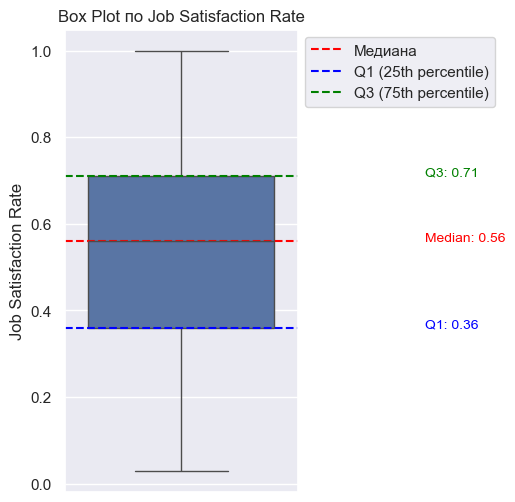

In [18]:
plt.figure(figsize=(3, 6))
sns.boxplot(data=train_data, y='job_satisfaction_rate')

# Вычисление квантилей и центрального значения
median = train_data['job_satisfaction_rate'].median()
q1 = train_data['job_satisfaction_rate'].quantile(0.25)
q3 = train_data['job_satisfaction_rate'].quantile(0.75)

# Отметка центрального значения и квантилей
plt.axhline(median, color='red', linestyle='--', label='Медиана')
plt.axhline(q1, color='blue', linestyle='--', label='Q1 (25th percentile)')
plt.axhline(q3, color='green', linestyle='--', label='Q3 (75th percentile)')

# Настройка заголовка и подписи осей
plt.title('Box Plot по Job Satisfaction Rate')
plt.ylabel('Job Satisfaction Rate')

# Вынесение легенды за пределы графика
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Добавление значений медианы и квантилей под графиком
plt.text(1.05, median, f'Median: {median:.2f}', color='red', fontsize=10)
plt.text(1.05, q1, f'Q1: {q1:.2f}', color='blue', fontsize=10)
plt.text(1.05, q3, f'Q3: {q3:.2f}', color='green', fontsize=10)

plt.show()

Определим, что 0.56 и больше это довольный сотрудник, если меньше - то недовольный.  
В теории, это значение может быть и другим, но пока у нас нет оснований уменьшать или увеличивать его, возможно в процессе работы переопределим этот показатель.

In [19]:
base = [train_data, features_test_data, test_target_data]
bin_target = 0.56
get_target_bin(base, 'job_satisfaction_rate', bin_target)
display(train_data.sample(2))
display(test_target_data.sample(2))
display(features_test_data.sample(2))

id       dept   level workload  employment_years last_year_promo  \
3257  645775  marketing  middle   medium                 2              no   
1491  796799  marketing  sinior     high                 4              no   

     last_year_violations  supervisor_evaluation  salary  \
3257                   no                      3   40800   
1491                   no                      3   79200   

      job_satisfaction_rate job_satisfaction_rate_bin  
3257                   0.36                 недоволен  
1491                   0.25                 недоволен

id  job_satisfaction_rate job_satisfaction_rate_bin
1644  188280                   0.56                 недоволен
491   478027                   0.45                 недоволен

id       dept   level workload  employment_years last_year_promo  \
1232  596615         hr  middle   medium                 7              no   
1730  727166  marketing  junior      low                 3              no   

     last_year_violations  supervisor_evaluation  salary  
1232                   no                      1   38400  
1730                   no                      3   20400

### train_data

In [20]:
base_1 = train_data.drop(columns=['id'])

#### num

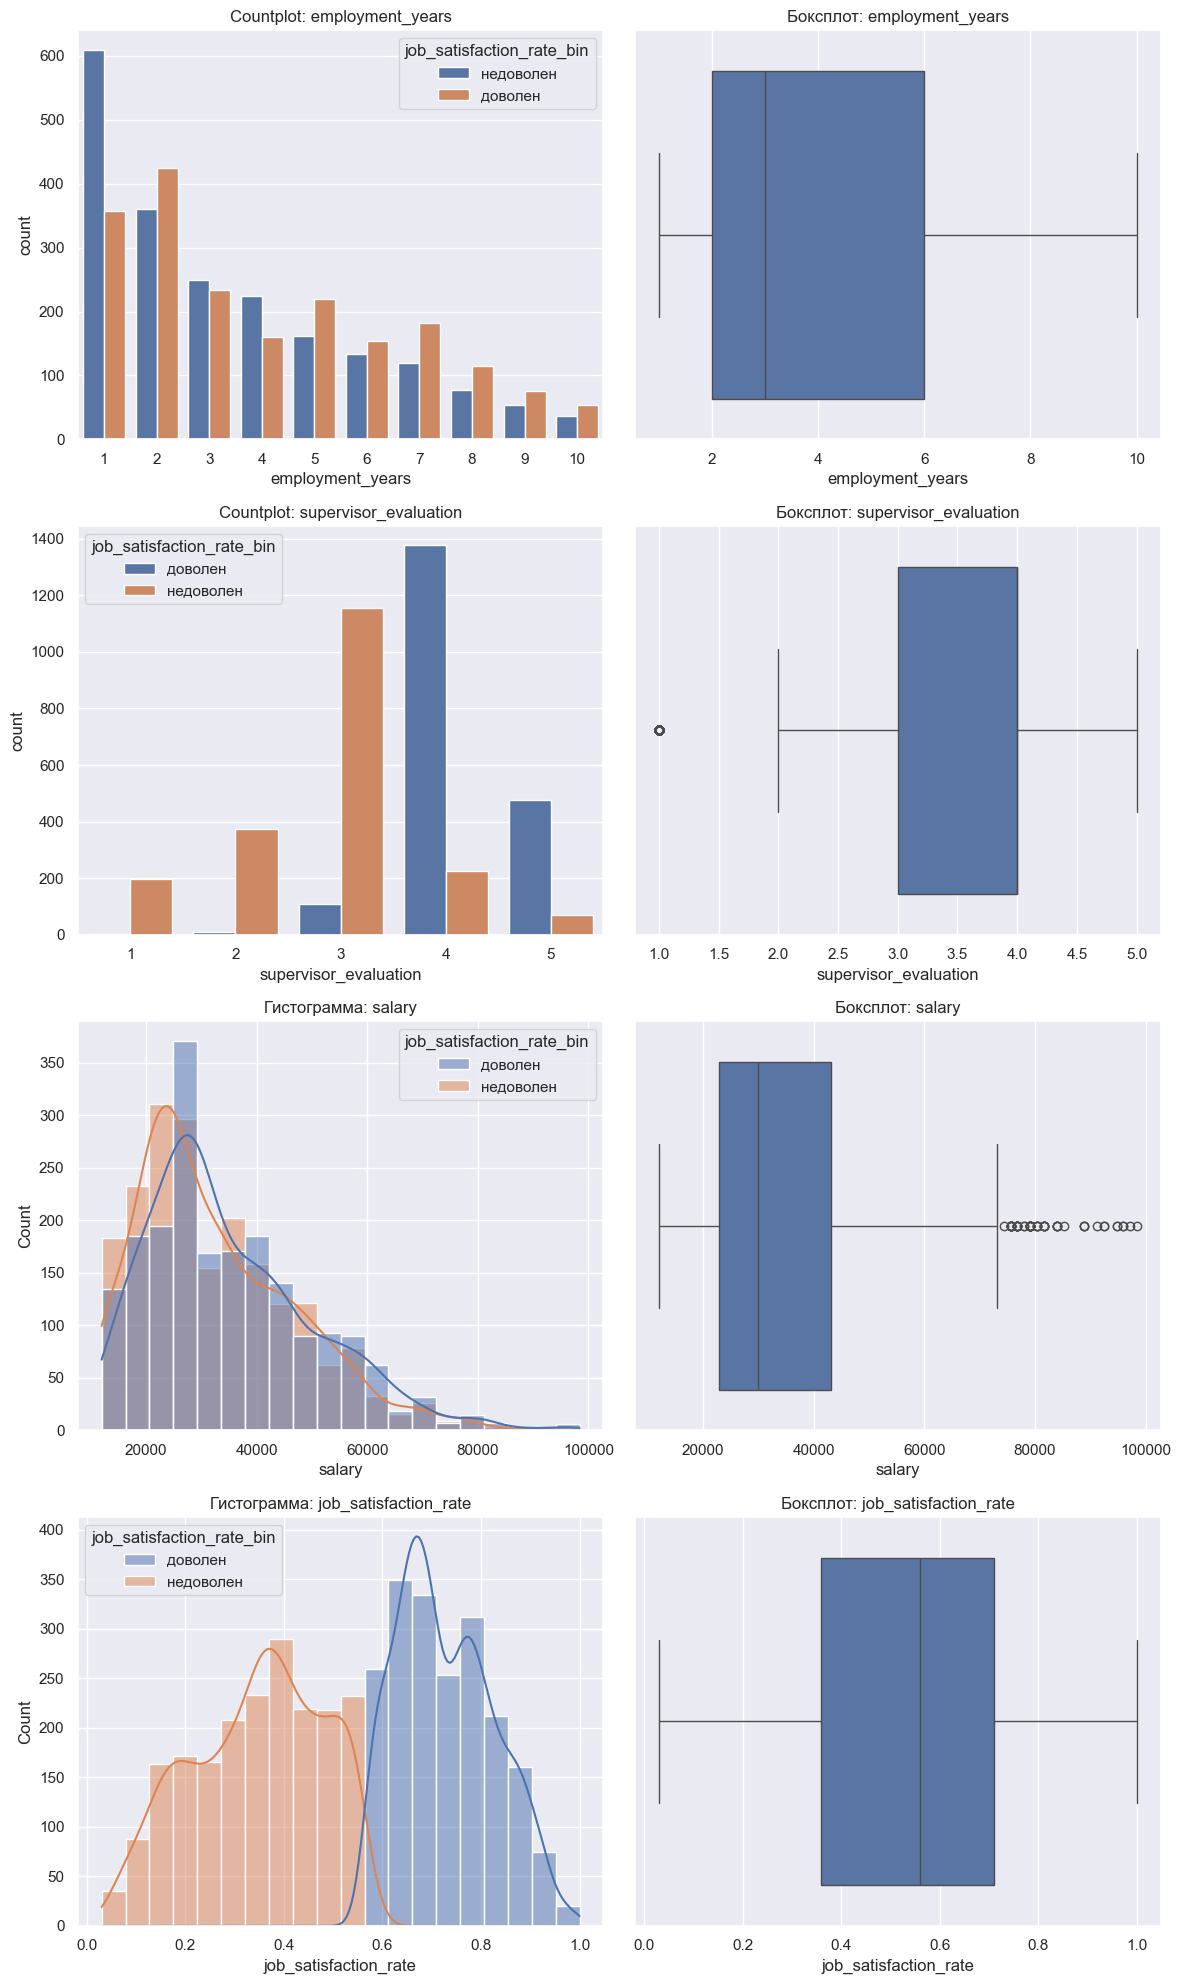

In [21]:
plot_combined(base_1, col=None, target='job_satisfaction_rate_bin', col_type=None, legend_loc='best')

Уточним, кто в основном попадает в группу "недоволен":  
1) Кто работает не так давно;  
2) Тот, кого ругает начальство;  
3) По ЗП в принципе не сильная разница между довольными/недовольными, тут сложно выделить;  

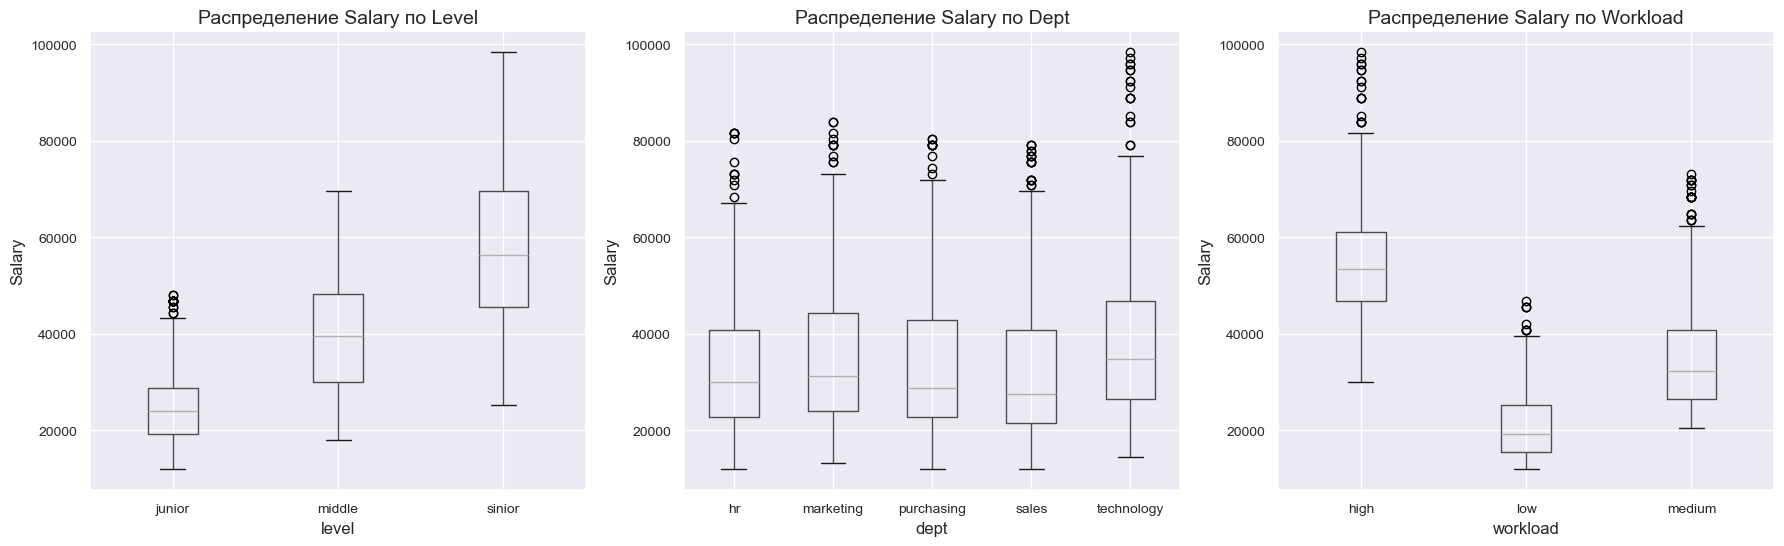

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# График 1: доход/грейд
base_1.boxplot(column='salary', by='level', ax=axs[0])
axs[0].set_title('Распределение Salary по Level', fontsize=14)
axs[0].set_ylabel('Salary', fontsize=12)
axs[0].tick_params(axis='both', labelsize=10)

# График 2: доход/департамент
base_1.boxplot(column='salary', by='dept', ax=axs[1])
axs[1].set_title('Распределение Salary по Dept', fontsize=14)
axs[1].set_ylabel('Salary', fontsize=12)
axs[1].tick_params(axis='both', labelsize=10)

# График 3: доход/загруженность
base_1.boxplot(column='salary', by='workload', ax=axs[2])
axs[2].set_title('Распределение Salary по Workload', fontsize=14)
axs[2].set_ylabel('Salary', fontsize=12)
axs[2].tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.suptitle('', fontsize=16)
plt.show()

# График 4: доход/удовлетворенность
mean_salary = base_1.groupby('job_satisfaction_rate')['salary'].mean().reset_index()
plot_density_heatmap(mean_salary, 'job_satisfaction_rate', 'salary')

Здесь распределение логичное:  
1) джуны получают меньше сеньеров;  
2) айтишники получают больше остальных, а остальные на одном уровне. Но вот тут логичность страдает - по моему опыту, сейлзы всегда имели и имеют больше... Странно.  
3) Ну и по загрузке - кто больше работает, тот больше получает.  
4) А увот удовлетворенность ничего такого нам не показывает - распределение зп практически равномерное по всем уровням, есть незначительная зависимость довольных и тем что зп больше  

Теперь рассмотрим категории сотрудников, как довольство/недовольство распределяется здесь

#### cat

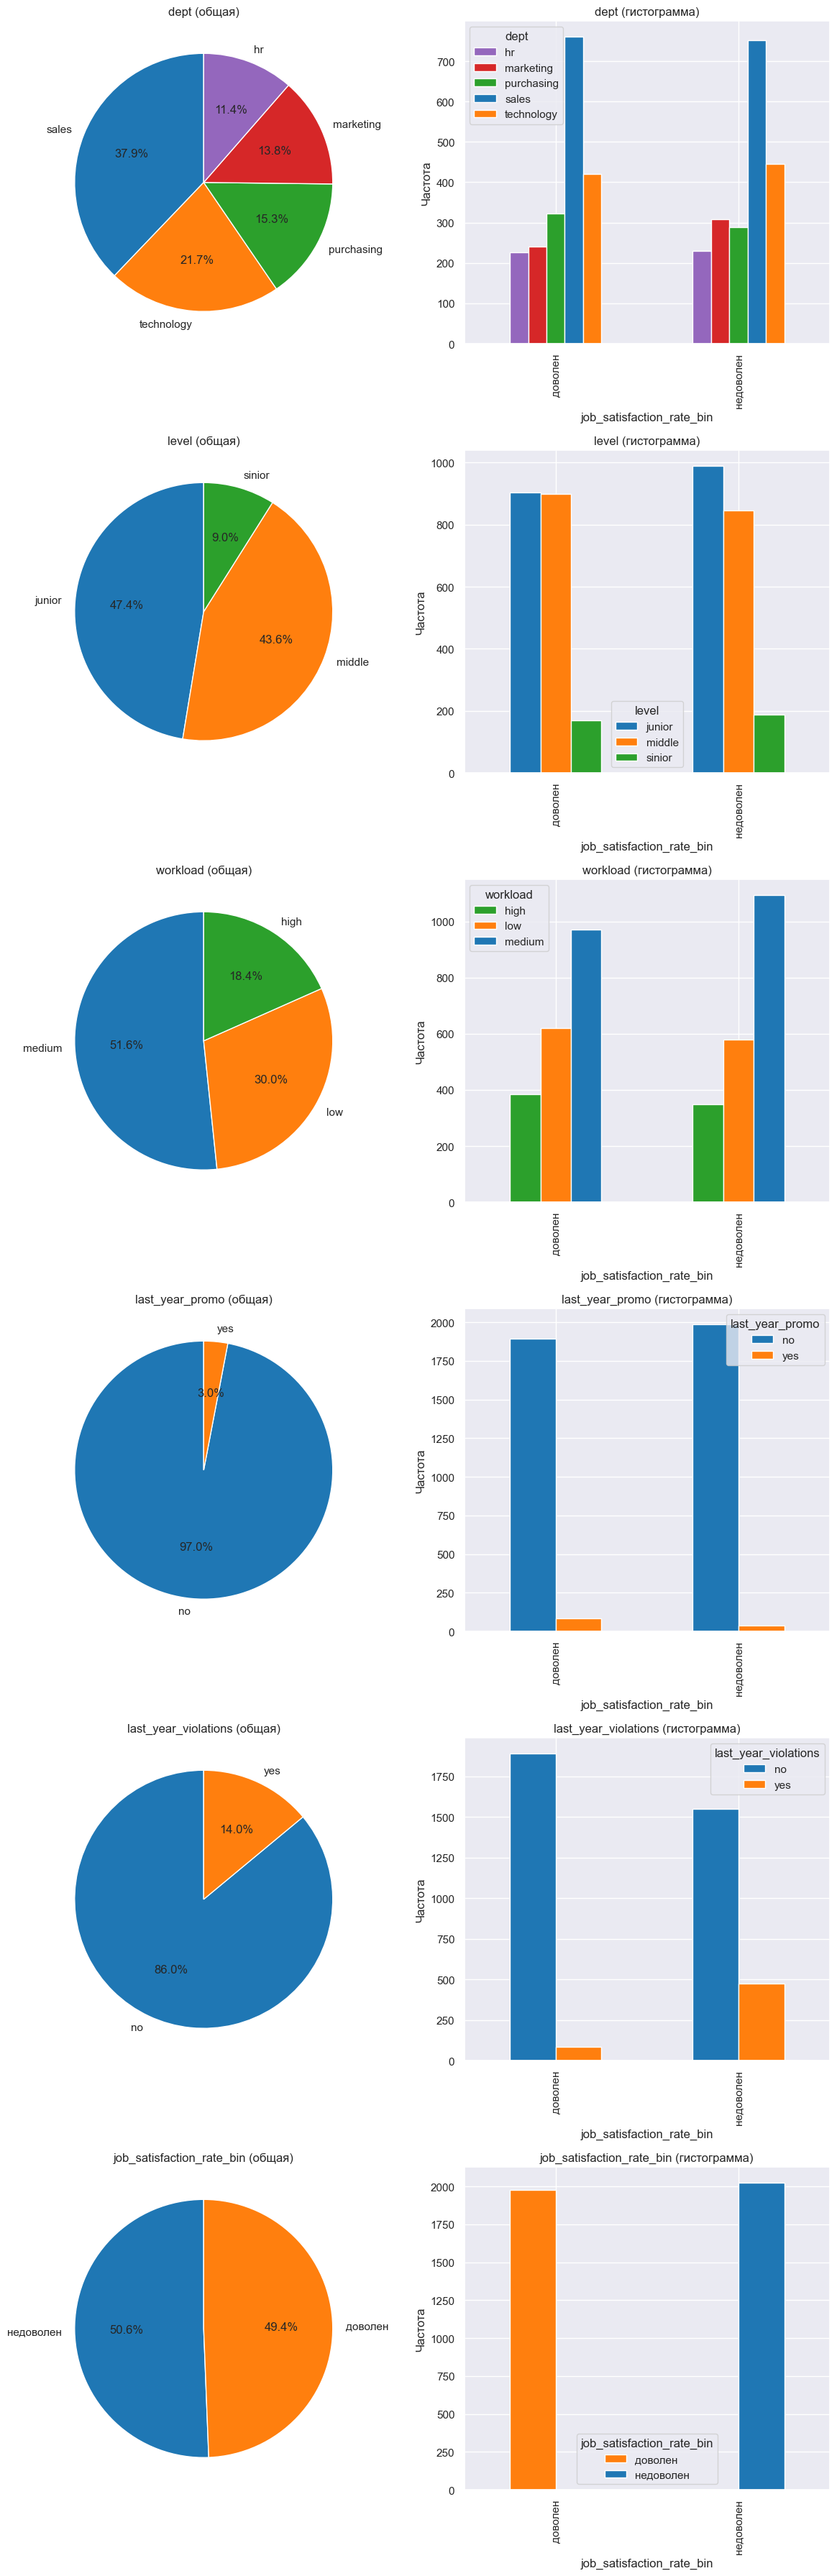

In [23]:
plot_categorical_columns(base_1, col=None, target='job_satisfaction_rate_bin')

#### Выводы

В целом большой зависимости по департаментам, грейду, загруженности, повышению и выговору, зависимостей не наблюдается - здесь все практически поровну.

### features_train_data

In [24]:
# эти данные также будут использовать и во второй задаче, поэтому изучим сразу здесь, а там не будем
base_2 = features_test_data.drop(columns=['id'])

#### num

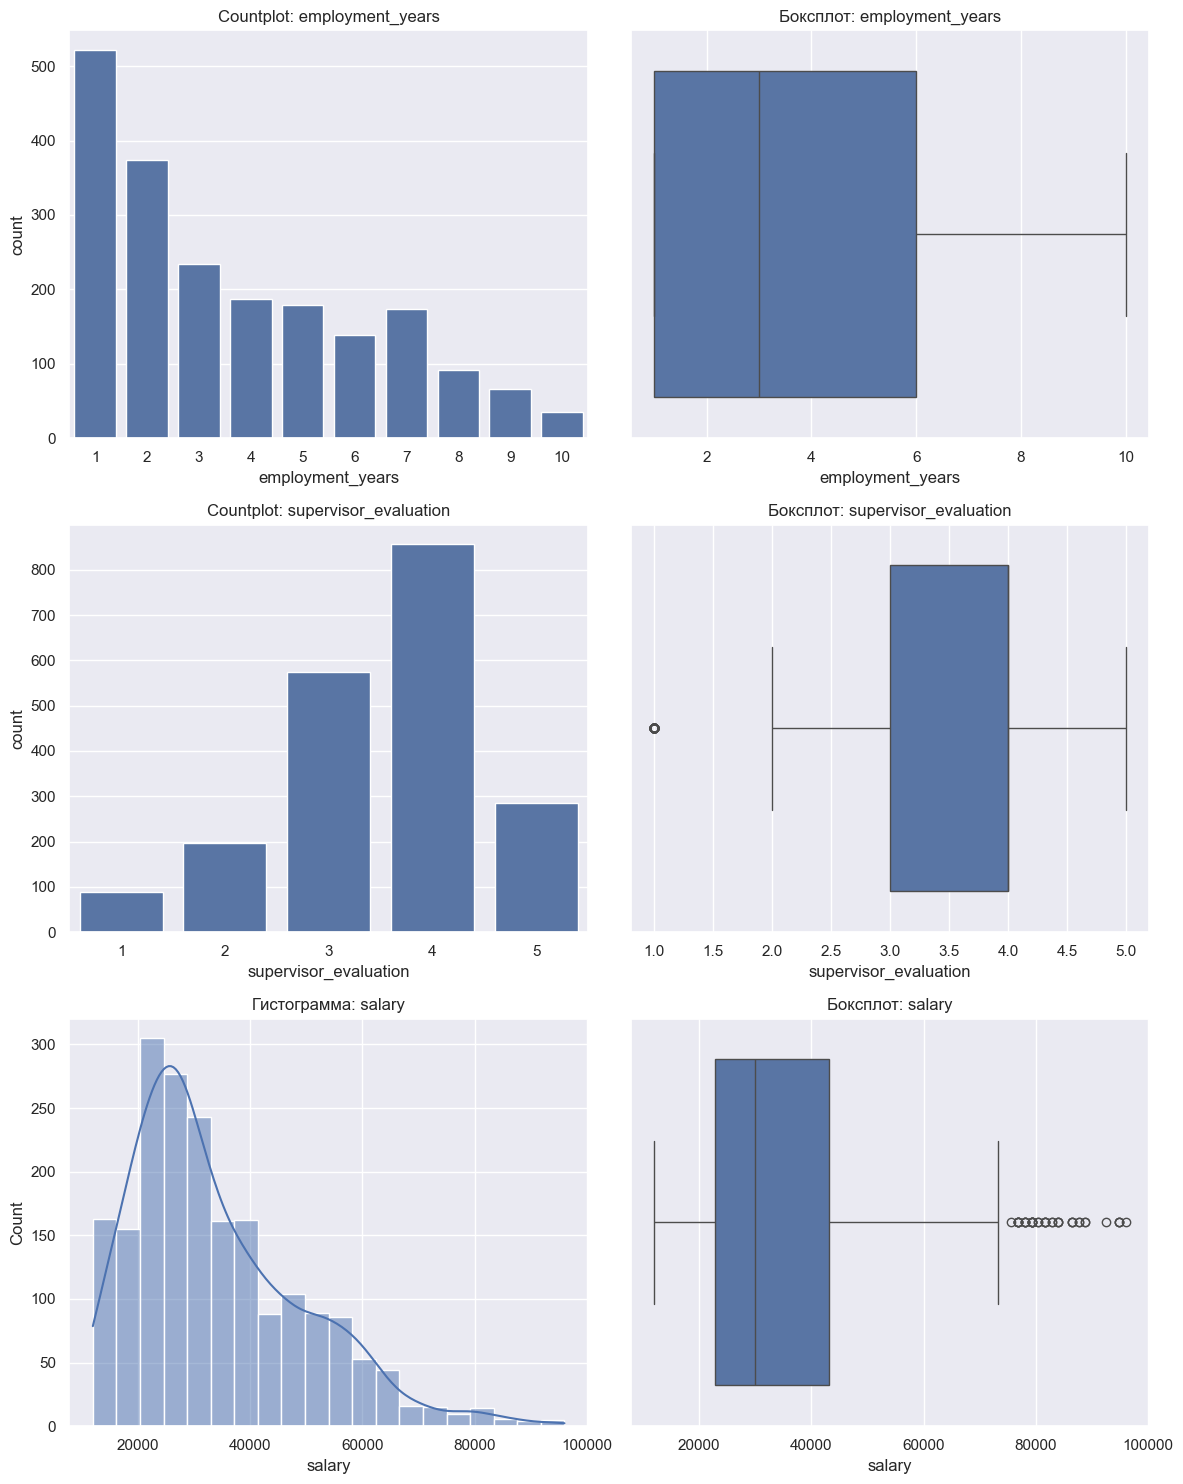

In [25]:
plot_combined(base_2, col=None, target=None, col_type=None, legend_loc='best')

#### cat

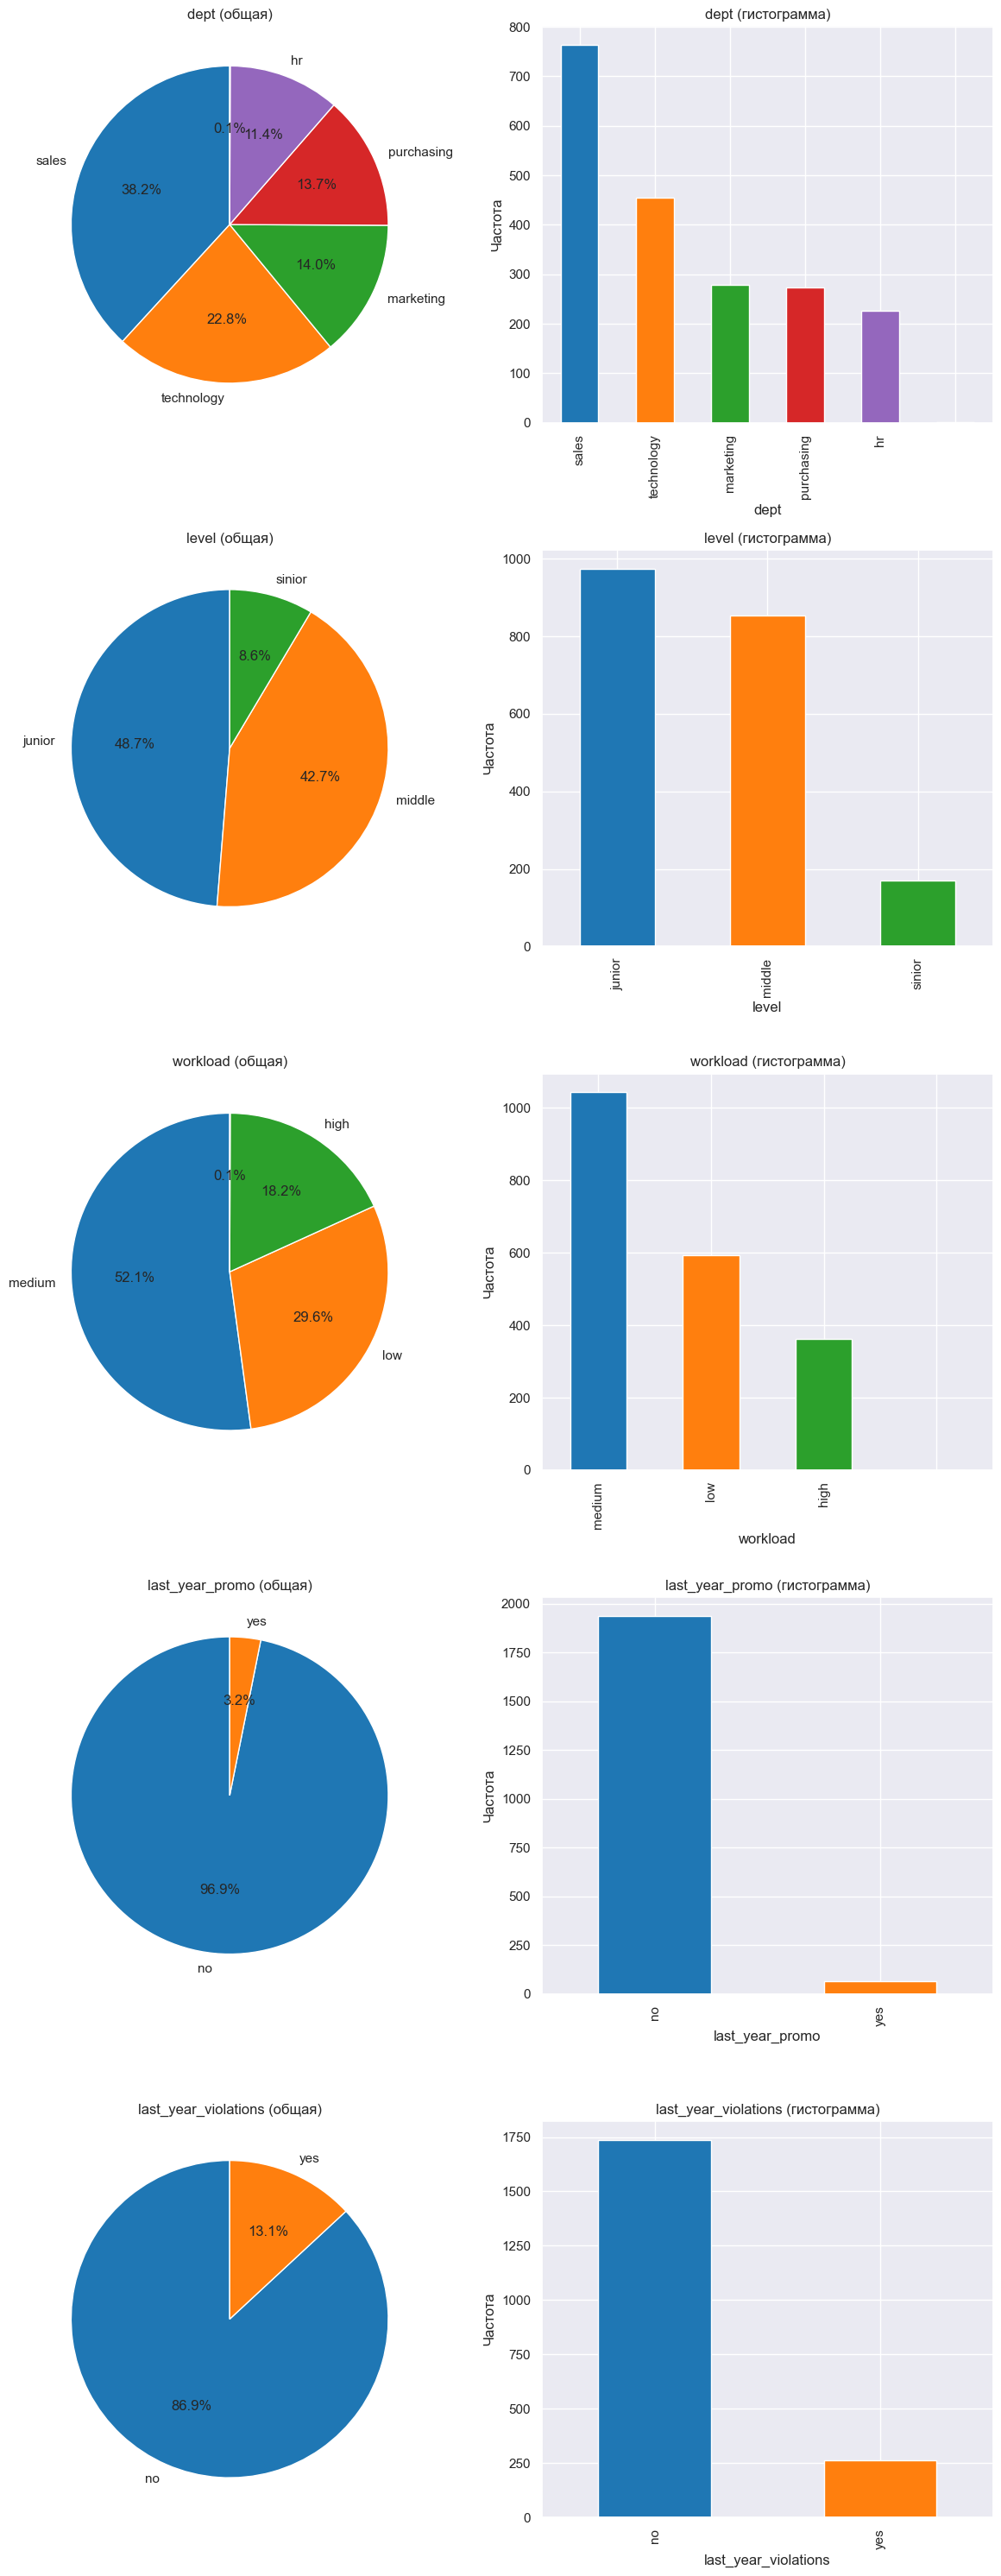

In [26]:
plot_categorical_columns(base_2, col=None, target='job_satisfaction_rate_bin')

In [27]:
# посмотрим, что там за 0.1% в dept и workload
check_unique_cat(base_2)

"Уникальные значения в столбце 'dept': ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan '']"

"Уникальные значения в столбце 'level': ['junior' 'middle' 'sinior' nan]"

"Уникальные значения в столбце 'workload': ['medium' 'low' 'high' '']"

"Уникальные значения в столбце 'last_year_promo': ['no' 'yes']"

"Уникальные значения в столбце 'last_year_violations': ['no' 'yes']"

In [28]:
# исправим опечатку, хоть в дальнейшем нам это и не помешает, но просто, чтобы было правильно
features_test_data['level'] = features_test_data['level'].replace('sinior', 'senior')

#### Выводы

Изучив данные - мы наблюдаем ряд пропусков.  
Первое, что приходит в голову - эти пропуски надо будет заменить по принципу "неизвестно".  
Но по ТЗ надо через pipeline и там заполним но наиболее встречаемым.

### test_target_data

In [29]:
base_3 = test_target_data.drop(columns=['id'])

#### num

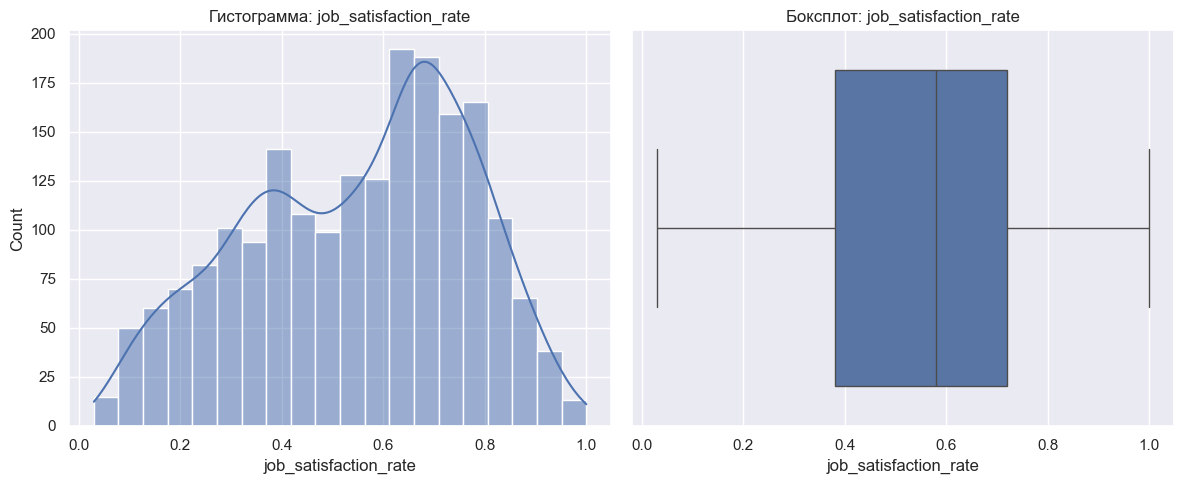

In [30]:
plot_combined(base_3)

#### cat

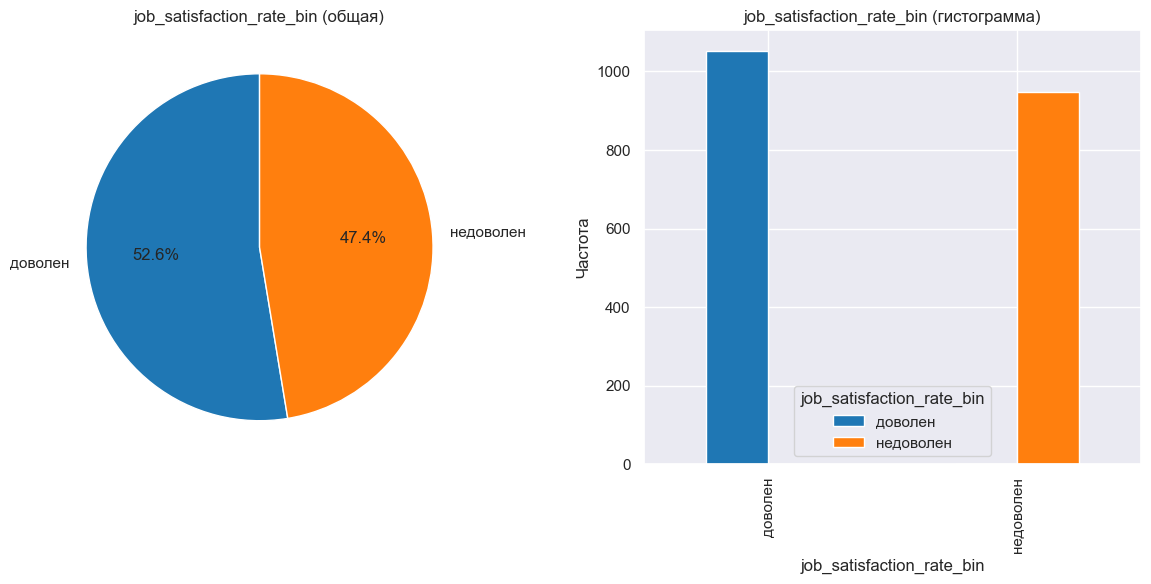

In [31]:
plot_categorical_columns(base_3, col=None, target='job_satisfaction_rate_bin')

#### Выводы

Как мне кажется - в этой компании очень уж много недовольных, почти половина...

### Сравнение распределения тренировочных и тестовых данных

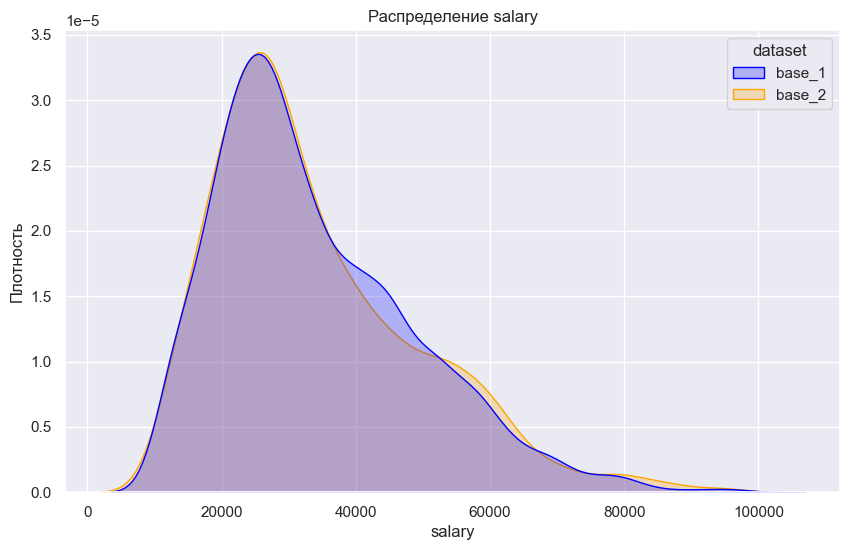

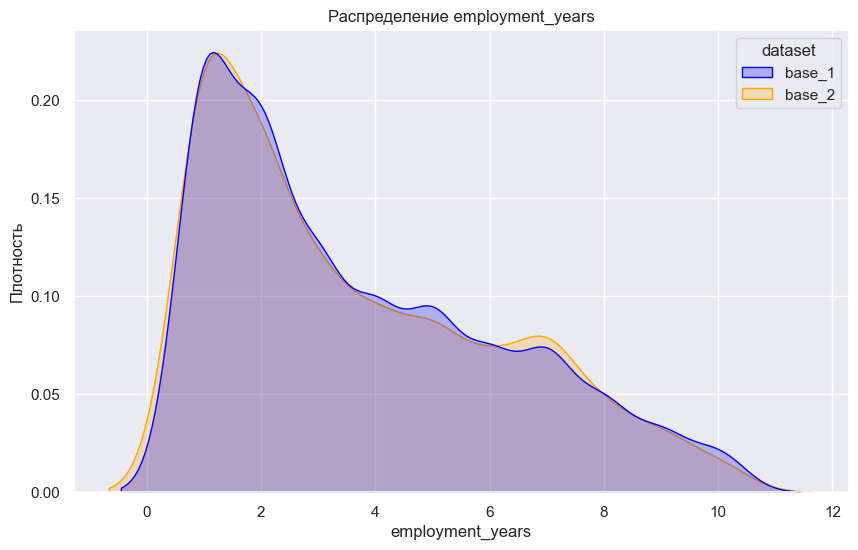

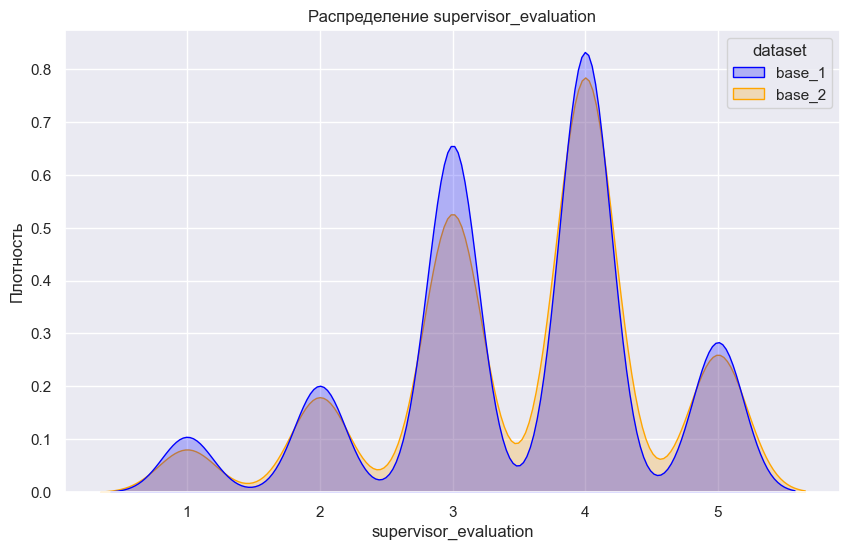

In [32]:
analyze_data([train_data, features_test_data], ['id'])

In [33]:
features_test_data_temp = features_test_data.merge(test_target_data[['id', 'job_satisfaction_rate']], on='id', how='left')
correlations = calculate_phik_correlations([train_data, features_test_data_temp], 'job_satisfaction_rate', drop_columns=['id', 'job_satisfaction_rate_bin'])
display(correlations)

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


base_1  base_2
Feature                              
dept                     0.08    0.03
level                    0.08    0.10
workload                 0.06    0.00
employment_years         0.33    0.31
last_year_promo          0.19    0.34
last_year_violations     0.56    0.55
supervisor_evaluation    0.76    0.77
salary                   0.17    0.17

В тренировочной и тестовой базах данные согласованы между собой.  
Есть незначительная разница между корреляциями workload и last_year_promo.  
Какие-то значимые отличия препятствующих обучению не наблюдаются.  

### Общие выводы

Первое, что было сделано при анализе данных - выделение удовлетворенности сотрудников, что является таргетом, в бинарный признак для оценки уровня удовлетворенности в компании в целом.  
И в целом в среднем по компании - число недовольных почти догнало число довольных сотрудников.  

Далее мы определили, кто чаще бывает недовольным:  
1) Кто работает не так давно;  
2) Тот, кого ругает начальство;  

По департаментам, грейду, загруженности, повышению и выговору, зависимостей не наблюдается - здесь уровень удовлетворенности распредился практически поровну.  

Что касается подготовки данных:  
1) Подготовим тренировочные и тестовые выборки для обучения моделей;  
2) Выделим категориальные данные для кодировки в ohe (dept, last_year_promo, last_year_violations) и ord (level, workload);  
3) Числовые данные стандартизируем, метод отберем в процессе подбора гиперпараметров;  

## Кореляционный анализ данных

### Анализ

interval columns not set, guessing: ['salary', 'job_satisfaction_rate']


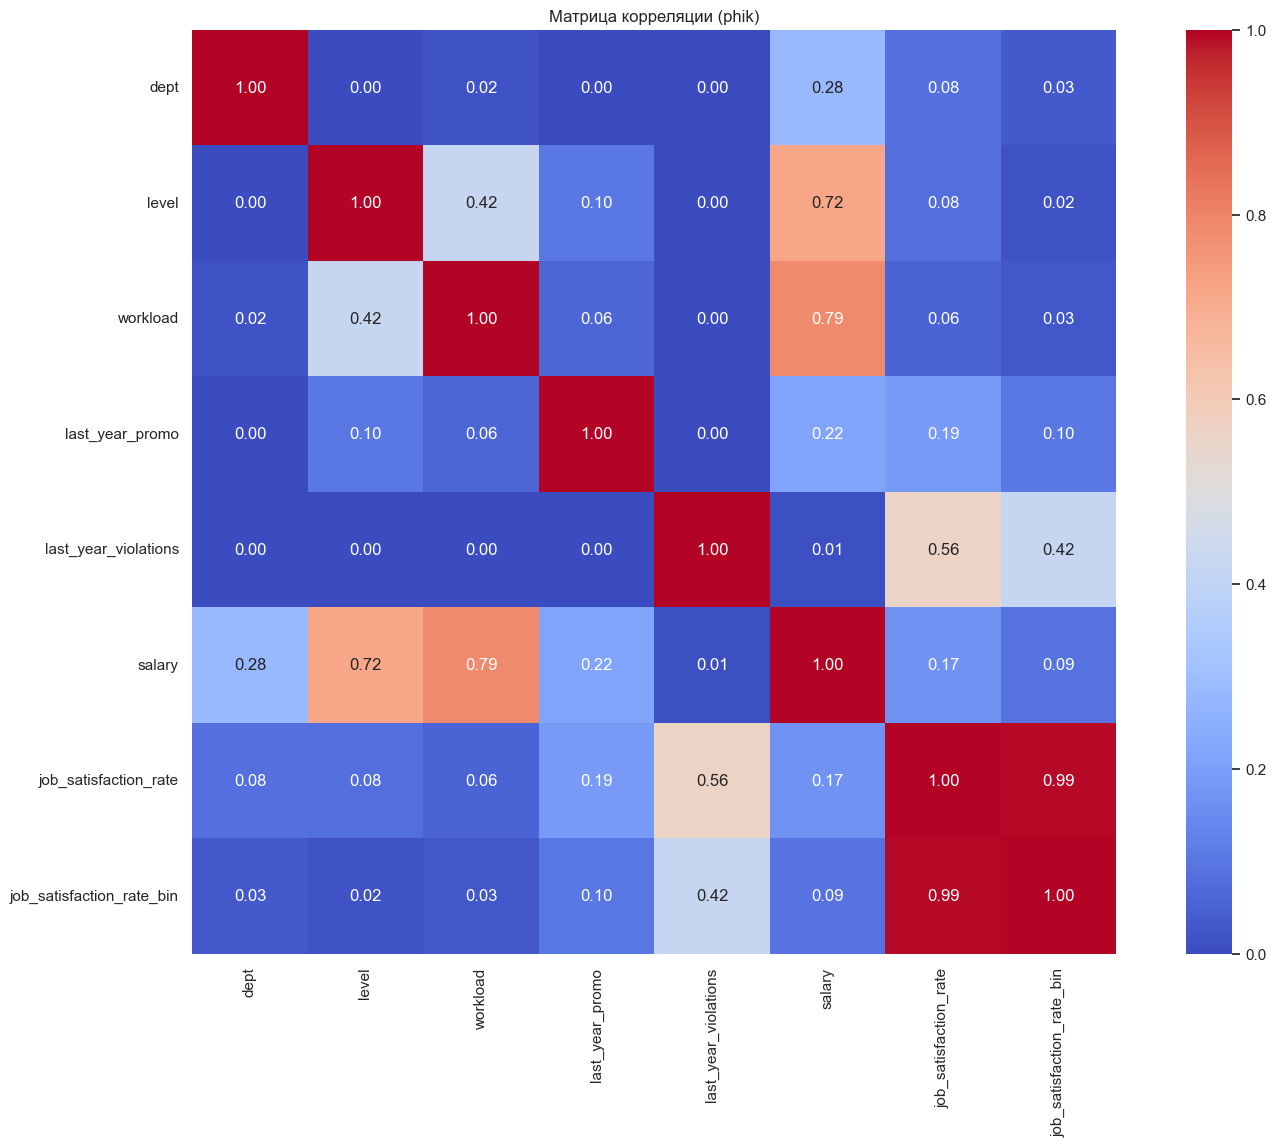

In [34]:
# проведем корреляционный анализ признаков, исключая указанные столбцы
train_data_cor = train_data.drop(columns=['id', 'employment_years', 'supervisor_evaluation'])
correlation_matrix = train_data_cor.phik_matrix()

# визуализируем
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Матрица корреляции (phik)')
plt.show()

# численные данные выбраны верно
# ЗЫ: знаю, что лучше писать руками признаки, но мне так нравится больше + я проверяю, чтобы все было нормально

### Корреляция

In [35]:
# выведем корреляцию удовлетворенности
corr = correlation_matrix['job_satisfaction_rate'].sort_values(ascending=False)

display("Сильня корреляция с уровнем удовлетворенности:")
display(corr[corr >= 0.16])

display("Слабая корреляция с уровнем удовлетворенности:")
display(corr[corr < 0.16])

'Сильня корреляция с уровнем удовлетворенности:'

job_satisfaction_rate       1.00
job_satisfaction_rate_bin   0.99
last_year_violations        0.56
last_year_promo             0.19
salary                      0.17
Name: job_satisfaction_rate, dtype: float64

'Слабая корреляция с уровнем удовлетворенности:'

dept       0.08
level      0.08
workload   0.06
Name: job_satisfaction_rate, dtype: float64

### VIF

In [36]:
get_vif(train_data, 'id', 'job_satisfaction_rate')

Признаки  VIF
0                       dept 1.01
1                      level 2.78
2                   workload 1.11
3           employment_years 1.86
4            last_year_promo 1.05
5       last_year_violations 1.09
6      supervisor_evaluation 1.91
7                     salary 2.11
8  job_satisfaction_rate_bin 2.06

### Выводы

Таким образом, изучив корреляцию между данными, наблюдается зависимость - недовольны те, кого руководство плохо оценивает и те кто косячил в прошлый период.

Мультиколлинеарности не наблюдается.

Значение VIF выше 5 требует внимания, а выше 10 — серьезного рассмотрения изменений в модели, в нашем же случае, все до 5, поэтому спокойно идем дальше.

## Подготовка данных и обучение

### Подготовка данных

In [37]:
# разделим на выборки
X_train, X_test, y_train, y_test = train_test_split(
    train_data.drop([
        'job_satisfaction_rate',
        'job_satisfaction_rate_bin',
        'id'
    ], axis=1),
    train_data['job_satisfaction_rate'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = train_data['job_satisfaction_rate'])

In [38]:
drop_duplicated(X_train)

1281

'Удаляем'

dept   level workload  employment_years last_year_promo  \
0     technology  junior   medium                 2              no   
1          sales  junior      low                 1              no   
2     technology  junior      low                 2              no   
3          sales  middle   medium                 5              no   
4      marketing  middle      low                 6              no   
...          ...     ...      ...               ...             ...   
2314  purchasing  sinior      low                 7              no   
2315  purchasing  middle     high                 9              no   
2316   marketing  middle   medium                 2              no   
2317       sales  sinior   medium                 3              no   
2318          hr  junior   medium                 4              no   

     last_year_violations  supervisor_evaluation  salary  
0                      no                      5   32400  
1                      no                      3   18000  
2                     yes                      4   19200  
3                      no                      3   38400  
4                      no                      4   26400  
...                   ...                    ...     ...  
2314                   no                      4   40800  
2315                   no                      5   54000  
2316                  yes                      4   36000  
2317                   no                      3   56400  
2318                   no                      5   22800  

[2319 rows x 8 columns]

In [39]:
X_train.shape, X_test.shape

((3600, 8), (400, 8))

In [40]:
# создаём списки с названиями признаков
# ohe_columns
ohe_columns = get_ohe_columns(X_train)
ohe_columns.append('dept')
# ord_columns.remove('job_satisfaction_rate_bin')
# ohe_columns.append('level')
# ohe_columns.append('workload')

# ord_columns
ord_columns = get_ord_columns(X_train)
ord_columns.remove('dept')
# ord_columns.remove('level')
# ord_columns.remove('workload')
# ord_columns.append('job_satisfaction_rate_bin')

# num_columns
num_columns = get_num_columns(X_train)
# num_columns.remove('id')

In [41]:
display("Признаки для OHE:", ohe_columns)
display("Признаки для Ordinal:", ord_columns)
display("Количественные признаки:", num_columns)

'Признаки для OHE:'

['last_year_promo', 'last_year_violations', 'dept']

'Признаки для Ordinal:'

['level', 'workload']

'Количественные признаки:'

['employment_years', 'supervisor_evaluation', 'salary']

### Подготовка пайплайна

In [42]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
# пока оставим most_frequent, возможно потом пересмотрим это решение
binary_columns = ['last_year_promo', 'last_year_violations']
dept_column = ['dept']

ohe_pipe = ColumnTransformer(
    transformers=[
        ('binary', Pipeline(steps=[
            ('replace_empty', ReplaceEmptyWithNaN()),
            ('simpleImputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
        ]), binary_columns),

        ('dept', Pipeline(steps=[
            ('replace_empty', ReplaceEmptyWithNaN()),
            ('simpleImputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), dept_column)
    ]
)

In [43]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [
        ('replace_empty', ReplaceEmptyWithNaN()),
        ('simpleImputer_before_ord', SimpleImputer(strategy='most_frequent')),
        ('ord', OrdinalEncoder(
            categories=[
                ['junior', 'middle', 'senior'],
                ['low', 'medium', 'high']
            ], 
            handle_unknown='use_encoded_value', unknown_value=np.nan
        )),
        ('simpleImputer_after_ord', SimpleImputer(strategy='most_frequent'))
    ]
)

In [44]:
minmax_pipeline = Pipeline(steps=[
    ('simpleImputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

standard_pipeline = Pipeline(steps=[
    ('simpleImputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

robust_pipeline = Pipeline(steps=[
    ('simpleImputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

# Объединение пайплайнов в ColumnTransformer
num_pipeline = ColumnTransformer(
    transformers=[
        ('minmax', minmax_pipeline, num_columns),
        ('standard', standard_pipeline, num_columns),
        ('robust', robust_pipeline, num_columns)
    ]
)

### Обучение модели

In [45]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

result = []
used_params = set()

def objective(trial):
    model_choice = trial.suggest_categorical('model', ['DecisionTreeRegr', 'LinearRegression', 'Ridge'])
    scaler_choice = trial.suggest_categorical('scaler', ['MinMaxScaler', 'StandardScaler', 'RobustScaler'])
    
    if model_choice == 'DecisionTreeRegr':
        max_depth = trial.suggest_int('max_depth', 22, 47)
        max_features = trial.suggest_int('max_features', 22, 39)
        min_samples_split = trial.suggest_int('min_samples_split', 6, 31)
        params_tuple = (model_choice, max_depth, max_features, min_samples_split)
    
    elif model_choice == 'LinearRegression':
        params_tuple = (model_choice)
        
    elif model_choice == 'Ridge':
        alpha = trial.suggest_loguniform('alpha', 1e-3, 1e3)
        params_tuple = (model_choice, alpha)
        
    if params_tuple in used_params:
        return 0
    used_params.add(params_tuple)

    if model_choice == 'DecisionTreeRegr':
        model = DecisionTreeRegressor(
            max_depth=max_depth,
            max_features=max_features, 
            min_samples_split=min_samples_split,
            random_state=RANDOM_STATE
        )
    
    elif model_choice == 'LinearRegression':
        model = LinearRegression()
        
    elif model_choice == 'Ridge':
        alpha = trial.params.get('alpha', 1.0)
        model = Ridge(alpha=alpha)
        
    if scaler_choice == 'MinMaxScaler':
        num_pipeline = Pipeline(steps=[
            ('simpleImputer', SimpleImputer(strategy='mean')),
            ('scaler', MinMaxScaler())
        ])
    elif scaler_choice == 'StandardScaler':
        num_pipeline = Pipeline(steps=[
            ('simpleImputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])
    else:
        num_pipeline = Pipeline(steps=[
            ('simpleImputer', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler())
        ])
        
    data_preprocessor = ColumnTransformer(
        [('ohe', ohe_pipe, ohe_columns),
         ('ord', ord_pipe, ord_columns),
         ('num', num_pipeline, num_columns)
        ], 
        remainder='passthrough'
    )

    pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', model)
    ])
    
    # Использование SMAPE в качестве метрики
    scoring_metric = make_scorer(smape, greater_is_better=True)
    scores = cross_val_score(pipe_final, X_train, y_train, cv=5, scoring=scoring_metric)
    mean_score = scores.mean()
    
    pipe_final.fit(X_train, y_train)
    y_pred = pipe_final.predict(X_test)
    
    test_score = smape(y_test, y_pred)

    result.append({
        'model': model_choice,
        'scaler': scaler_choice,
        'max_depth': trial.params.get('max_depth', None),
        'max_features': trial.params.get('max_features', None),
        'min_samples_split': trial.params.get('min_samples_split', None),
        'alpha': trial.params.get('alpha', None),
        'C': trial.params.get('C', None),
        'epsilon': trial.params.get('epsilon', None),
        'kernel': trial.params.get('kernel', None),
        'scoring_metric_train': mean_score,
        'scoring_metric_train_test': test_score,
        'pipeline': pipe_final
    })

    return mean_score

study = optuna.create_study(direction='minimize')

for _ in tqdm(range(N), desc="Trials"):
    study.optimize(objective, n_trials=N)

# Находим индекс с минимальным значением scoring_metric_train_test
best_index = min(range(len(result)), key=lambda i: result[i]['scoring_metric_train_test'])
best_metrics = result[best_index]
best_params = best_metrics.copy()

final_output = {**best_params}

Trials: 100%|██████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.77it/s]


### Лучшая модель

In [46]:
best_params_df = pd.DataFrame(list(final_output.items()), columns=['Параметры', 'Значение'])
display(format_display("Лучшая модель и параметры на тренировочных данных"))
filtered_df = best_params_df[best_params_df['Значение'].notna()]
display(filtered_df)

Параметры  \
0                       model   
1                      scaler   
2                   max_depth   
3                max_features   
4           min_samples_split   
9        scoring_metric_train   
10  scoring_metric_train_test   
11                   pipeline   

                                             Значение  
0                                    DecisionTreeRegr  
1                                      StandardScaler  
2                                                  42  
3                                                  28  
4                                                  13  
9                                               15.20  
10                                              13.92  
11  (ColumnTransformer(remainder='passthrough',\n ...

In [47]:
result_df_1 = pd.DataFrame(result)
result_df_1 = result_df_1.sort_values(by=['scoring_metric_train_test'], ascending=True)
display(result_df_1.head(5))
display(result_df_1.info())

model          scaler  max_depth  max_features  \
3   DecisionTreeRegr  StandardScaler      42.00         28.00   
27  DecisionTreeRegr    RobustScaler      34.00         30.00   
14  DecisionTreeRegr    RobustScaler      30.00         34.00   
9   DecisionTreeRegr  StandardScaler      22.00         39.00   
4   DecisionTreeRegr    RobustScaler      36.00         27.00   

    min_samples_split  alpha     C epsilon kernel  scoring_metric_train  \
3               13.00    NaN  None    None   None                 15.20   
27              20.00    NaN  None    None   None                 15.41   
14              23.00    NaN  None    None   None                 15.34   
9                9.00    NaN  None    None   None                 15.08   
4               17.00    NaN  None    None   None                 15.31   

    scoring_metric_train_test  \
3                       13.92   
27                      13.97   
14                      14.06   
9                       14.08   
4                       14.08   

                                             pipeline  
3   (ColumnTransformer(remainder='passthrough',\n ...  
27  (ColumnTransformer(remainder='passthrough',\n ...  
14  (ColumnTransformer(remainder='passthrough',\n ...  
9   (ColumnTransformer(remainder='passthrough',\n ...  
4   (ColumnTransformer(remainder='passthrough',\n ...

<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, 3 to 32
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   model                      34 non-null     object 
 1   scaler                     34 non-null     object 
 2   max_depth                  17 non-null     float64
 3   max_features               17 non-null     float64
 4   min_samples_split          17 non-null     float64
 5   alpha                      16 non-null     float64
 6   C                          0 non-null      object 
 7   epsilon                    0 non-null      object 
 8   kernel                     0 non-null      object 
 9   scoring_metric_train       34 non-null     float64
 10  scoring_metric_train_test  34 non-null     float64
 11  pipeline                   34 non-null     object 
dtypes: float64(6), object(6)
memory usage: 3.5+ KB


None

In [48]:
unique_models = result_df_1['model'].unique()

result_df = pd.DataFrame()
for model in unique_models:
    min_row = result_df_1[result_df_1['model'] == model].nsmallest(1, 'scoring_metric_train_test')
    result_df = pd.concat([result_df, min_row])
result_df.reset_index(drop=True, inplace=True)
display(format_display('Лучшие результаты по моделям'))
display(result_df)

model          scaler  max_depth  max_features  \
0  DecisionTreeRegr  StandardScaler      42.00         28.00   
1             Ridge    MinMaxScaler        NaN           NaN   
2  LinearRegression    MinMaxScaler        NaN           NaN   

   min_samples_split  alpha     C epsilon kernel  scoring_metric_train  \
0              13.00    NaN  None    None   None                 15.20   
1                NaN  28.82  None    None   None                 27.20   
2                NaN    NaN  None    None   None                 27.86   

   scoring_metric_train_test  \
0                      13.92   
1                      26.41   
2                      27.35   

                                            pipeline  
0  (ColumnTransformer(remainder='passthrough',\n ...  
1  (ColumnTransformer(remainder='passthrough',\n ...  
2  (ColumnTransformer(remainder='passthrough',\n ...

In [49]:
display(format_display('Лучшая модель, ее настройки и параметры'))
best_model = best_metrics['pipeline']
display(best_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  ColumnTransformer(transformers=[('binary',
                                                                                   Pipeline(steps=[('replace_empty',
                                                                                                    ReplaceEmptyWithNaN()),
                                                                                                   ('simpleImputer',
                                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                                   ('ohe',
                                                                                                    OneHotEncoder(drop='if_binary',
                                                                                                                  handle_unknown='ignore'))]),
                                                                                   ['last_year_promo',
                                                                                    'last_year_vio...
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleImputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=42, max_features=28,
                                       min_samples_split=13,
                                       random_state=20))])

### Предсказание на тестовых данных

In [50]:
# предсказание на тестовой таблице
features_test_data['predictions_job_rate'] = best_model.predict(features_test_data)
features_test_data = merge_base([features_test_data, test_target_data], 'id', 'inner')
display(features_test_data[['predictions_job_rate', 'job_satisfaction_rate', 'job_satisfaction_rate_bin']])

predictions_job_rate  job_satisfaction_rate job_satisfaction_rate_bin
0                     0.88                   0.79                   доволен
1                     0.67                   0.72                   доволен
2                     0.66                   0.64                   доволен
3                     0.66                   0.60                   доволен
4                     0.83                   0.75                   доволен
...                    ...                    ...                       ...
1995                  0.52                   0.56                 недоволен
1996                  0.17                   0.14                 недоволен
1997                  0.16                   0.11                 недоволен
1998                  0.43                   0.43                 недоволен
1999                  0.57                   0.67                   доволен

[2000 rows x 3 columns]

In [51]:
test_score = smape(features_test_data['job_satisfaction_rate'], features_test_data['predictions_job_rate'])
display(format_display('Результат метрики SMAPE на тестовой таблице'))
display(round(test_score, 2))

14.03

### Выводы

В этой части был собран pipeline для обработки данных:  
    1) категориальных: 'last_year_promo', 'last_year_violations', 'dept' - были обработаны с помощью One-Hot Encoding, причем первые два с помощью if_binary, последний через drop_first;  
    2) порядковых категориальных: 'level', 'workload' с помощью OrdinalEncoder по возрастанию;  
    3) числовые были обработаны с помощью разных скалеров - 'MinMaxScaler', 'StandardScaler', 'RobustScaler' с последующим выявлением лучшего метода;  
    
Категориальные пропуски были заменены на моду, а числовые - на средние значения.

Далее с помощью метода Optuna была подобрана оптимальная модель с гиперпараметрами.  
На тренировке показатели получились следующие:  

Параметры	Значение  
0	model	DecisionTreeRegr  
1	scaler	MinMaxScaler  
2	max_depth	41  
3	max_features	25  
4	min_samples_split	25  
10	scoring_metric_train	16.04  
11	scoring_metric_train_test	14.39   

На мой взгляд, у DecisionTreeRegr больше вариаций для подбора оптимального решения, чем у LinearRegression, поэтому она и справилась лучше.

С помощью лучшей модели были обработаны тестовые данные и получены предсказания.  
Метрика SMAPE выдала значение - 14.23  
Согласно ТЗ, метрика должна была получится <= 15, чего в итоге и получилось достичь.

## Задача 2

Целевой признак в этой задаче отличается: это quit — увольнение сотрудника из компании.  
Обучить как минимум три модели.  
Как минимум для двух из них подобрать гиперпараметры.  
Проверить качество лучшей модели.  
Метрика оценки качества в этой задаче — ROC-AUC.  
Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке.  

## Исследовательский анализ данных

### train_data_quit

#### num

In [52]:
base_4 = train_data_quit.drop(columns=['id'])

In [53]:
display(base_4)

dept   level workload  employment_years last_year_promo  \
0          sales  middle     high                 2              no   
1          sales  junior   medium                 2              no   
2     purchasing  middle   medium                 5              no   
3          sales  junior   medium                 2              no   
4      marketing  junior   medium                 2              no   
...          ...     ...      ...               ...             ...   
3995       sales  junior   medium                 4              no   
3996       sales  middle     high                 9              no   
3997  purchasing  junior      low                 2              no   
3998  purchasing  middle   medium                 2              no   
3999       sales  junior   medium                 2              no   

     last_year_violations  supervisor_evaluation  salary quit  
0                      no                      4   54000   no  
1                      no                      4   27600   no  
2                      no                      1   37200   no  
3                     yes                      3   24000  yes  
4                      no                      5   25200   no  
...                   ...                    ...     ...  ...  
3995                   no                      3   26400   no  
3996                   no                      4   52800   no  
3997                  yes                      4   12000  yes  
3998                   no                      4   33600   no  
3999                   no                      3   27600  yes  

[4000 rows x 9 columns]

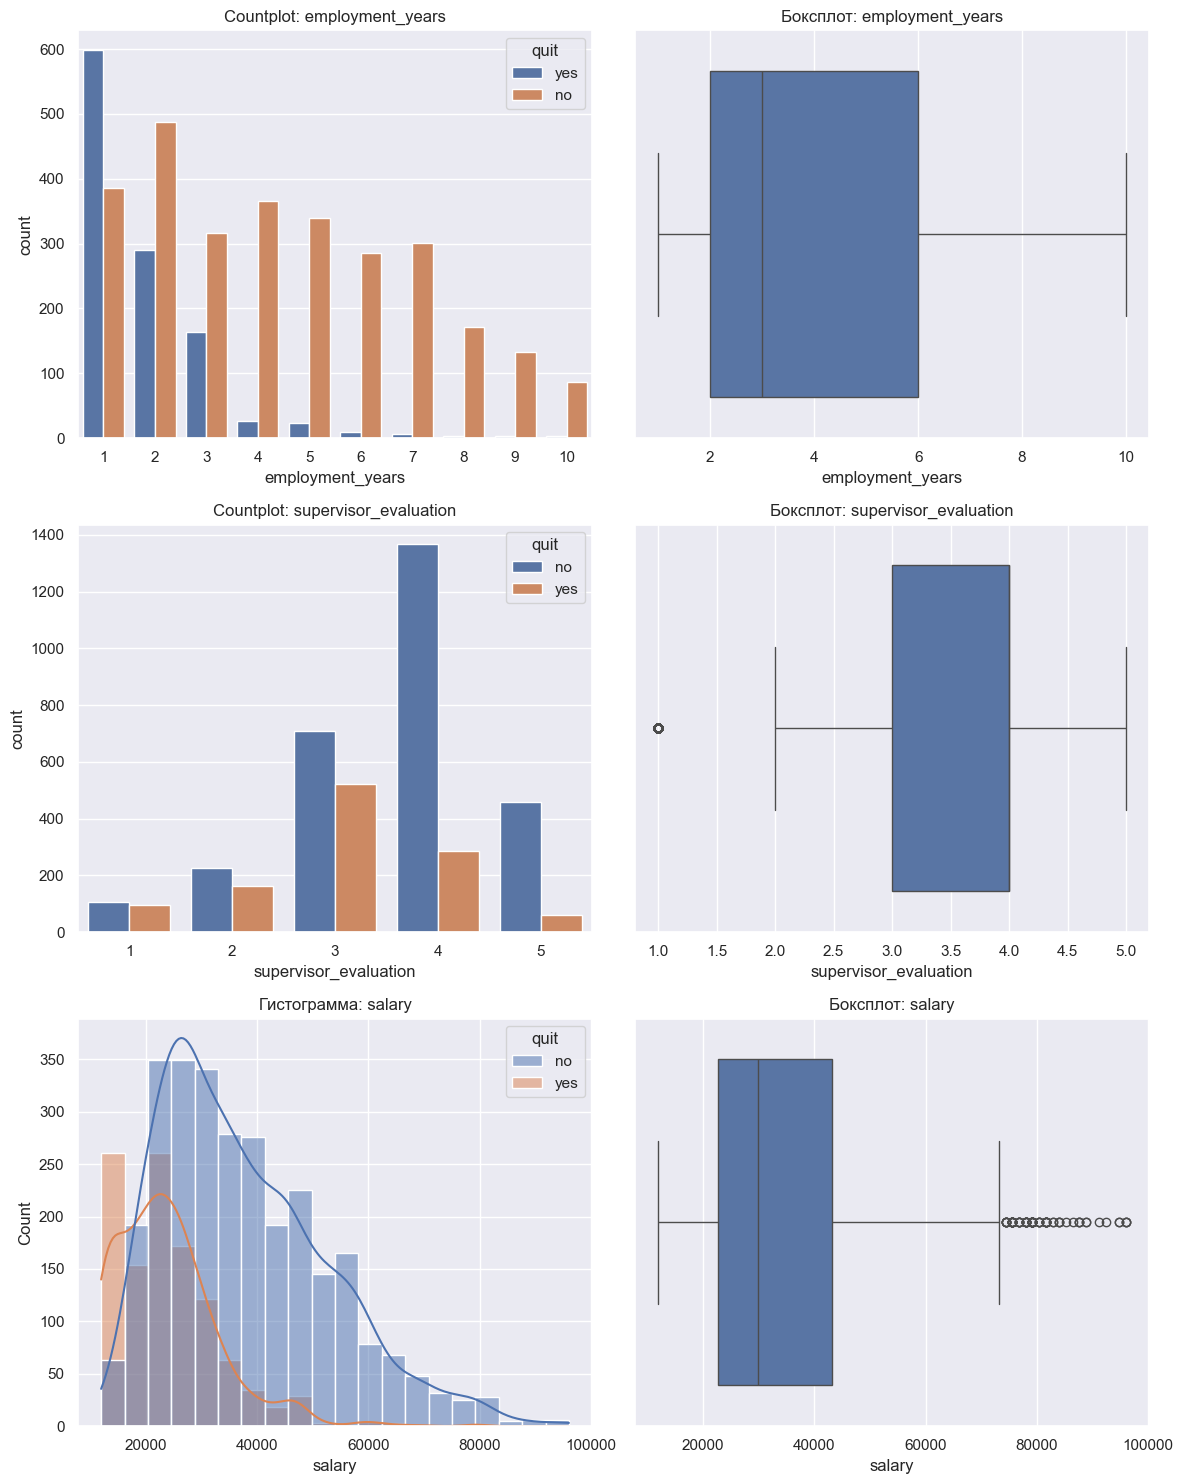

In [54]:
plot_combined(base_4, col=None, target='quit', col_type=None, legend_loc='best')

#### cat

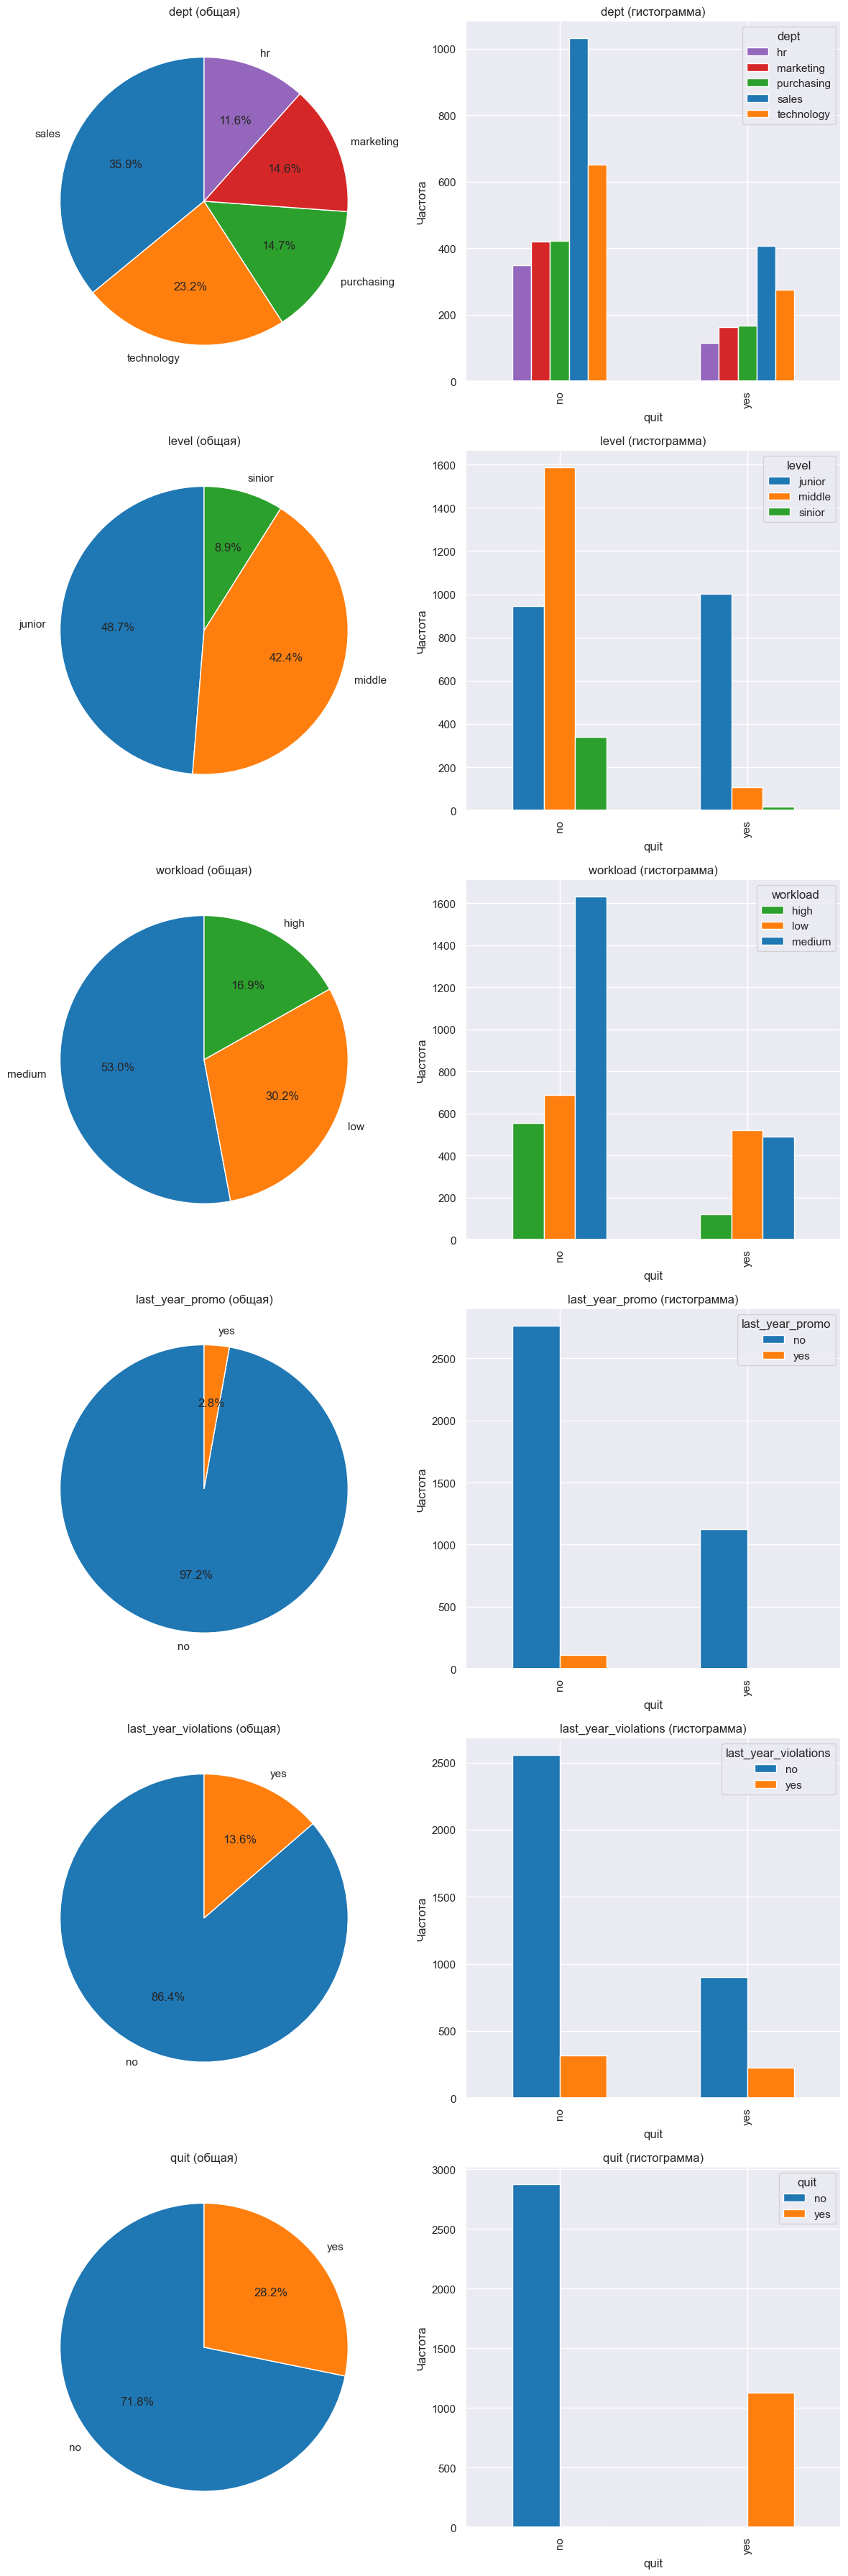

In [55]:
plot_categorical_columns(base_4, col=None, target='quit')

Отдельно сравним средний доход тех, кто ушел и тех, кто остался.

In [56]:
mean_salary = base_4.groupby('quit')['salary'].mean().reset_index()
mean_salary.columns = ['quit', 'average_salary']
display(mean_salary)

quit  average_salary
0   no        37702.23
1  yes        23885.11

Дополнительно изучим относительные величины по имеющимся у нас данным

In [57]:
display(base_4)

dept   level workload  employment_years last_year_promo  \
0          sales  middle     high                 2              no   
1          sales  junior   medium                 2              no   
2     purchasing  middle   medium                 5              no   
3          sales  junior   medium                 2              no   
4      marketing  junior   medium                 2              no   
...          ...     ...      ...               ...             ...   
3995       sales  junior   medium                 4              no   
3996       sales  middle     high                 9              no   
3997  purchasing  junior      low                 2              no   
3998  purchasing  middle   medium                 2              no   
3999       sales  junior   medium                 2              no   

     last_year_violations  supervisor_evaluation  salary quit  
0                      no                      4   54000   no  
1                      no                      4   27600   no  
2                      no                      1   37200   no  
3                     yes                      3   24000  yes  
4                      no                      5   25200   no  
...                   ...                    ...     ...  ...  
3995                   no                      3   26400   no  
3996                   no                      4   52800   no  
3997                  yes                      4   12000  yes  
3998                   no                      4   33600   no  
3999                   no                      3   27600  yes  

[4000 rows x 9 columns]

'Результаты для dept:'

Число_no  Число_yes  Соотношение_всех_no  Соотношение_всех_yes  \
dept                                                                         
hr            348.00     116.00                 0.12                  0.10   
marketing     419.00     163.00                 0.15                  0.14   
purchasing    422.00     166.00                 0.15                  0.15   
sales        1031.00     407.00                 0.36                  0.36   
technology    652.00     276.00                 0.23                  0.24   

            Соотношение_no  Соотношение_yes  
dept                                         
hr                    0.75             0.25  
marketing             0.72             0.28  
purchasing            0.72             0.28  
sales                 0.72             0.28  
technology            0.70             0.30

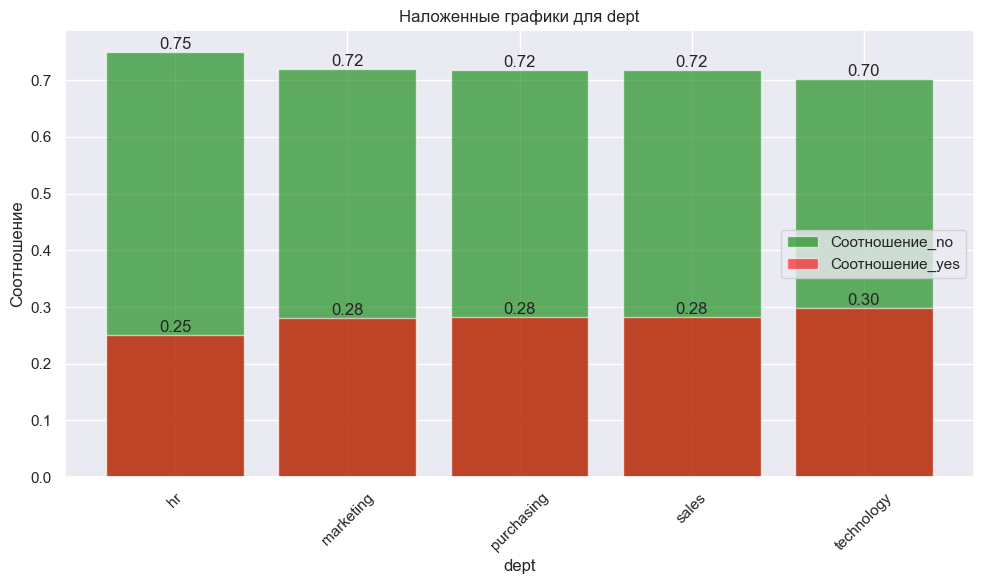

'Результаты для level:'

Число_no  Число_yes  Соотношение_всех_no  Соотношение_всех_yes  \
level                                                                    
junior    946.00    1003.00                 0.33                  0.89   
middle   1586.00     108.00                 0.55                  0.10   
sinior    340.00      17.00                 0.12                  0.02   

        Соотношение_no  Соотношение_yes  
level                                    
junior            0.49             0.51  
middle            0.94             0.06  
sinior            0.95             0.05

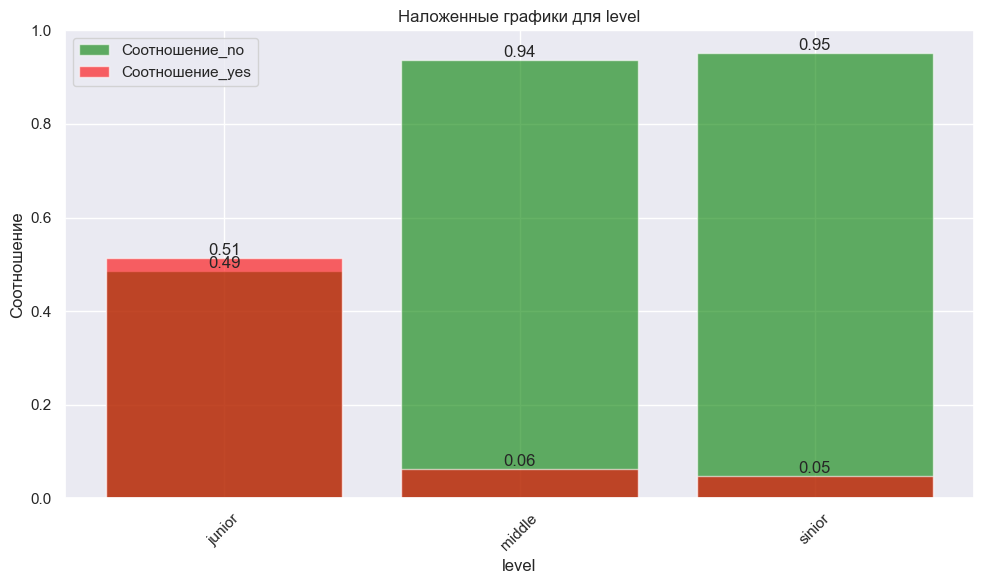

'Результаты для workload:'

Число_no  Число_yes  Соотношение_всех_no  Соотношение_всех_yes  \
workload                                                                   
high        553.00     121.00                 0.19                  0.11   
low         689.00     519.00                 0.24                  0.46   
medium     1630.00     488.00                 0.57                  0.43   

          Соотношение_no  Соотношение_yes  
workload                                   
high                0.82             0.18  
low                 0.57             0.43  
medium              0.77             0.23

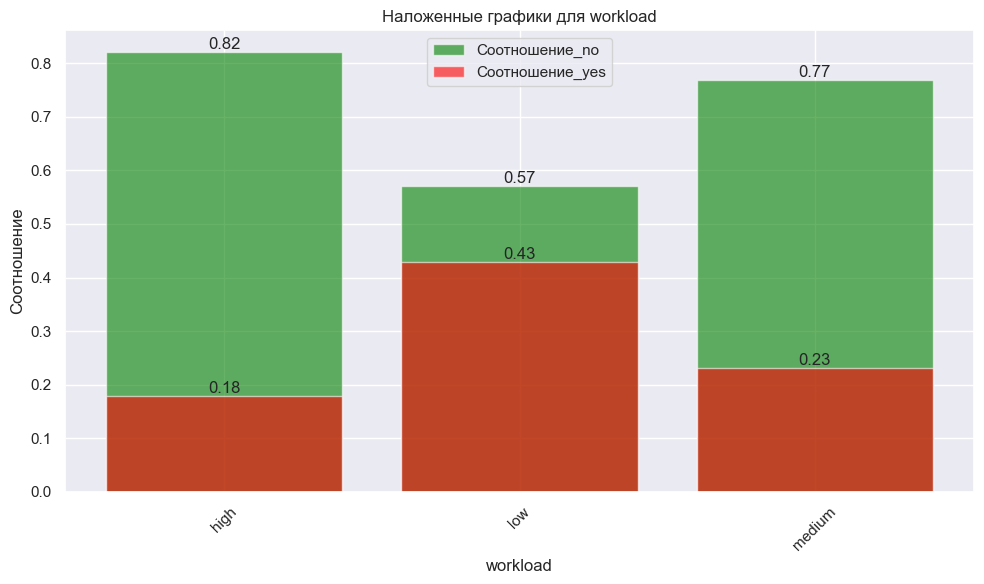

'Результаты для employment_years:'

Число_no  Число_yes  Соотношение_всех_no  \
employment_years                                             
1                   386.00     599.00                 0.13   
2                   487.00     290.00                 0.17   
3                   316.00     163.00                 0.11   
4                   366.00      27.00                 0.13   
5                   339.00      23.00                 0.12   
6                   286.00      10.00                 0.10   
7                   301.00       7.00                 0.10   
8                   171.00       3.00                 0.06   
9                   133.00       3.00                 0.05   
10                   87.00       3.00                 0.03   

                  Соотношение_всех_yes  Соотношение_no  Соотношение_yes  
employment_years                                                         
1                                 0.53            0.39             0.61  
2                                 0.26            0.63             0.37  
3                                 0.14            0.66             0.34  
4                                 0.02            0.93             0.07  
5                                 0.02            0.94             0.06  
6                                 0.01            0.97             0.03  
7                                 0.01            0.98             0.02  
8                                 0.00            0.98             0.02  
9                                 0.00            0.98             0.02  
10                                0.00            0.97             0.03

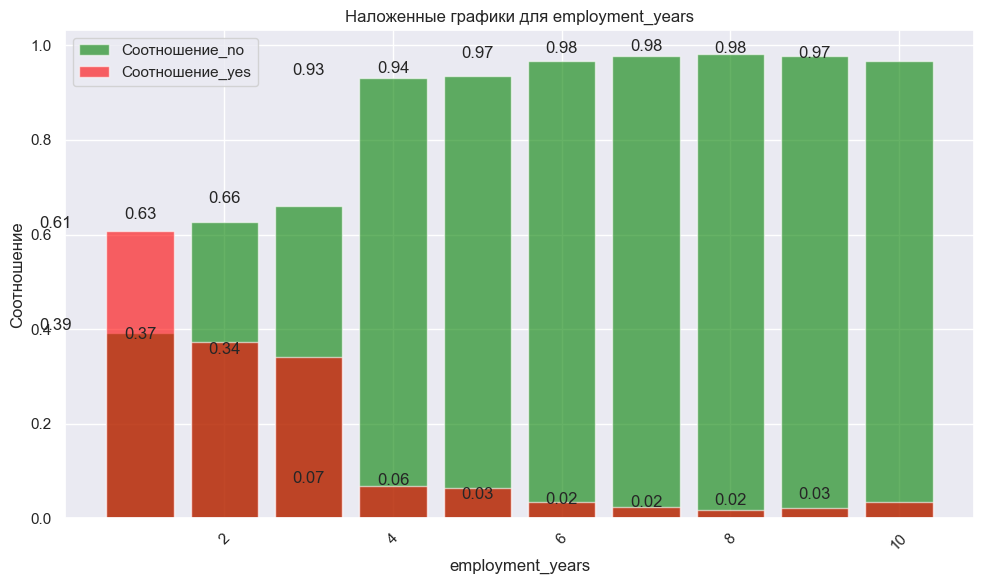

'Результаты для supervisor_evaluation:'

Число_no  Число_yes  Соотношение_всех_no  \
supervisor_evaluation                                             
1                        107.00      95.00                 0.04   
2                        227.00     164.00                 0.08   
3                        710.00     523.00                 0.25   
4                       1368.00     286.00                 0.48   
5                        460.00      60.00                 0.16   

                       Соотношение_всех_yes  Соотношение_no  Соотношение_yes  
supervisor_evaluation                                                         
1                                      0.08            0.53             0.47  
2                                      0.15            0.58             0.42  
3                                      0.46            0.58             0.42  
4                                      0.25            0.83             0.17  
5                                      0.05            0.88             0.12

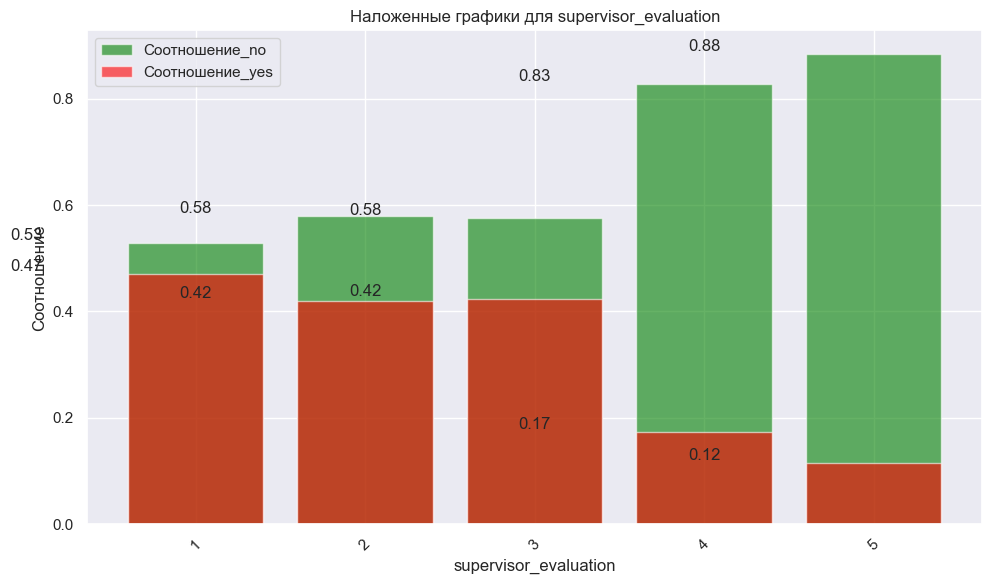

'Результаты для last_year_promo:'

Число_no  Число_yes  Соотношение_всех_no  \
last_year_promo                                             
no                2760.00    1127.00                 0.96   
yes                112.00       1.00                 0.04   

                 Соотношение_всех_yes  Соотношение_no  Соотношение_yes  
last_year_promo                                                         
no                               1.00            0.71             0.29  
yes                              0.00            0.99             0.01

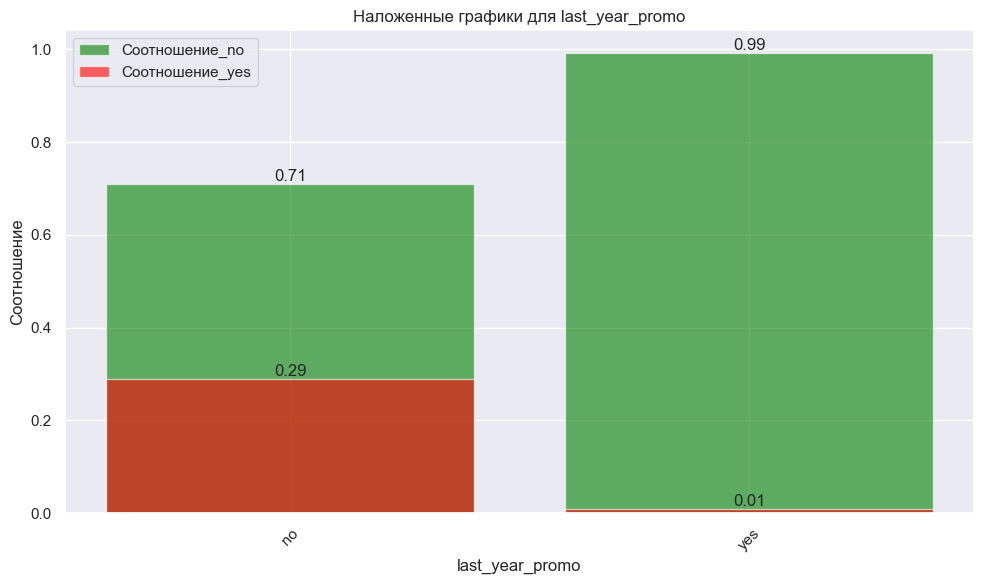

'Результаты для last_year_violations:'

Число_no  Число_yes  Соотношение_всех_no  \
last_year_violations                                             
no                     2555.00     900.00                 0.89   
yes                     317.00     228.00                 0.11   

                      Соотношение_всех_yes  Соотношение_no  Соотношение_yes  
last_year_violations                                                         
no                                    0.80            0.74             0.26  
yes                                   0.20            0.58             0.42

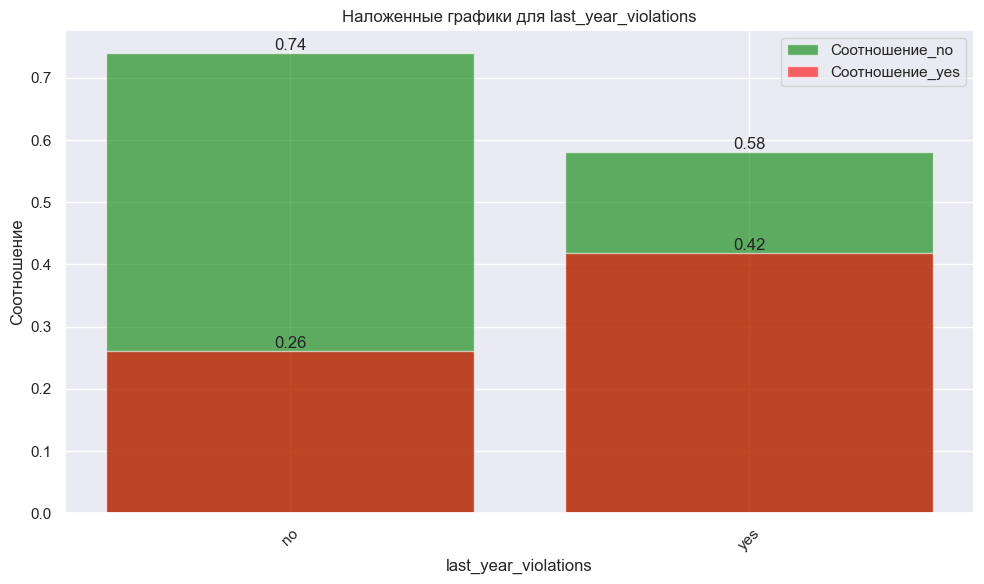

In [58]:
cols = ['dept', 'level', 'workload', 'employment_years', 'supervisor_evaluation', 'last_year_promo', 'last_year_violations']

results = {}
for column in cols:
    grouped = base_4.groupby(['quit', column]).size().reset_index(name='Число')
    total_counts = grouped.groupby('quit')['Число'].transform('sum')
    grouped['Соотношение_всех'] = grouped['Число'] / total_counts
    pivoted = grouped.pivot(index=column, columns='quit', values=['Число', 'Соотношение_всех']).fillna(0)
    pivoted.columns = [f'{metric}_{quit}' for metric, quit in pivoted.columns]
    
    pivoted['Соотношение_no'] = grouped[grouped['quit'] == 'no'].pivot(index=column, columns='quit', values='Число').fillna(0)
    pivoted['Соотношение_yes'] = grouped[grouped['quit'] == 'yes'].pivot(index=column, columns='quit', values='Число').fillna(0)
    
    pivoted[['Соотношение_no', 'Соотношение_yes']] = pivoted[['Соотношение_no', 'Соотношение_yes']].div(
        pivoted[['Соотношение_no', 'Соотношение_yes']].sum(axis=1), axis=0
    )
    
    results[column] = pivoted

for column, result in results.items():
    display(f"Результаты для {column}:")
    display(result)
    
    plt.figure(figsize=(10, 6))
    plt.bar(result.index, result['Соотношение_no'], label='Соотношение_no', color='green', alpha=0.6)
    plt.bar(result.index, result['Соотношение_yes'], label='Соотношение_yes', color='red', alpha=0.6)
    
    for i in range(len(result)):
        plt.text(i, result['Соотношение_no'].iloc[i], f"{result['Соотношение_no'].iloc[i]:.2f}", ha='center', va='bottom')
        plt.text(i, result['Соотношение_yes'].iloc[i], f"{result['Соотношение_yes'].iloc[i]:.2f}", ha='center', va='bottom')

    plt.title(f'Наложенные графики для {column}')
    plt.xlabel(column)
    plt.ylabel('Соотношение')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Выводы

Какую картину наблюдаем по увольнениям в компании:  
1) Стаж - наибольшая текучка наблюдается в первые 3 года работы, причем после 5 лет - ее почти нет;  
2) Оценке качества работы - все выглядит логично, кто хорошо работает, тот и не дергается;  
3) Доходу - основной отток наблюдается в зоне до 40.000, причем средний доход ушедших 23800, а оставшихся - 37700;  
4) Отдел - больше всего уходят из отдела technology;  
5) Грейд - преобладает текучка по джунам, что тоже выглядит логично - или не справился или вырос;  
6) Загруженность - у кого низкая, тот чаще уходит, а у тех у кого высокая - им некогда думать об уходе, они работают;  
7) Повышение дохода - никто из ушедших так и не дождался повышения ЗП, может быть это и есть одна из ключевых причин?;  
8) Выговоры - у кого был выговор, чаще увольняется, чем те у кого их не было;  
9) Уходы - почти 30% компании, что очень много, а если вспомнить удовлетворенность, то там и вовсе 40% недовольных было...  

Типичный увольняющийся сотрудник — это, как правило, молодой специалист с небольшим стажем (до 3х лет включительно), работающий в отделе technology, с доходом до 40,000, который не получил повышения и, возможно, не нашел удовлетворения в своей работе, а также у которого легкая загруженность и оценка работы руководством ниже 4х.  
Высокий уровень текучки и недовольства среди сотрудников подчеркивает необходимость улучшения условий труда, систематического повышения зарплат и возможностей для карьерного роста.

### Визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников

In [59]:
# предскажем удовлетворенность сотрудников в новой выборке с учетом прошлой лучшей модели
train_data_quit['predictions_job_rate'] = best_model.predict(train_data_quit)
display(train_data_quit)

id        dept   level workload  employment_years last_year_promo  \
0     723290       sales  middle     high                 2              no   
1     814010       sales  junior   medium                 2              no   
2     155091  purchasing  middle   medium                 5              no   
3     257132       sales  junior   medium                 2              no   
4     910140   marketing  junior   medium                 2              no   
...      ...         ...     ...      ...               ...             ...   
3995  588809       sales  junior   medium                 4              no   
3996  672059       sales  middle     high                 9              no   
3997  536432  purchasing  junior      low                 2              no   
3998  692133  purchasing  middle   medium                 2              no   
3999  853842       sales  junior   medium                 2              no   

     last_year_violations  supervisor_evaluation  salary quit  \
0                      no                      4   54000   no   
1                      no                      4   27600   no   
2                      no                      1   37200   no   
3                     yes                      3   24000  yes   
4                      no                      5   25200   no   
...                   ...                    ...     ...  ...   
3995                   no                      3   26400   no   
3996                   no                      4   52800   no   
3997                  yes                      4   12000  yes   
3998                   no                      4   33600   no   
3999                   no                      3   27600  yes   

      predictions_job_rate  
0                     0.64  
1                     0.82  
2                     0.34  
3                     0.34  
4                     0.69  
...                    ...  
3995                  0.53  
3996                  0.85  
3997                  0.55  
3998                  0.52  
3999                  0.49  

[4000 rows x 11 columns]

На полученных предсказаниях визуализируем и сравним данные об увольнениях и удовлетворенности

C:\Users\root6\AppData\Local\Temp\ipykernel_8481952\2089441985.py:15: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



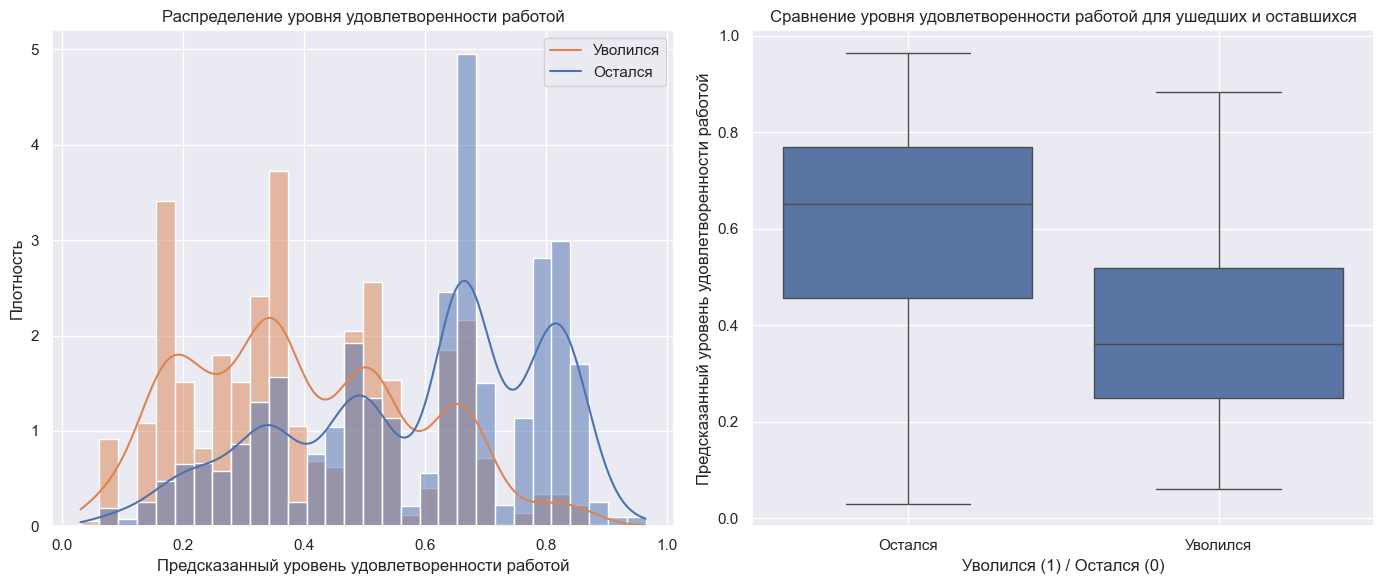

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(data=train_data_quit, x='predictions_job_rate', hue='quit', 
             bins=30, kde=True, stat='density', common_norm=False, alpha=0.5, ax=axes[0])
axes[0].set_title('Распределение уровня удовлетворенности работой')
axes[0].set_xlabel('Предсказанный уровень удовлетворенности работой')
axes[0].set_ylabel('Плотность')
axes[0].legend(title='', labels=['Уволился', 'Остался'])
axes[0].grid(True)

sns.boxplot(x='quit', y='predictions_job_rate', data=train_data_quit, ax=axes[1])
axes[1].set_title('Сравнение уровня удовлетворенности работой для ушедших и оставшихся')
axes[1].set_xlabel('Уволился (1) / Остался (0)')
axes[1].set_ylabel('Предсказанный уровень удовлетворенности работой')
axes[1].set_xticklabels(['Остался', 'Уволился'])
axes[1].grid(True)

# Отображение графиков
plt.tight_layout()
plt.show()

Получается аналитики были правы - действительно, чем ниже удовлетворенность, тем больше уходов.

### Корреляция

#### Анализ

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'predictions_job_rate']


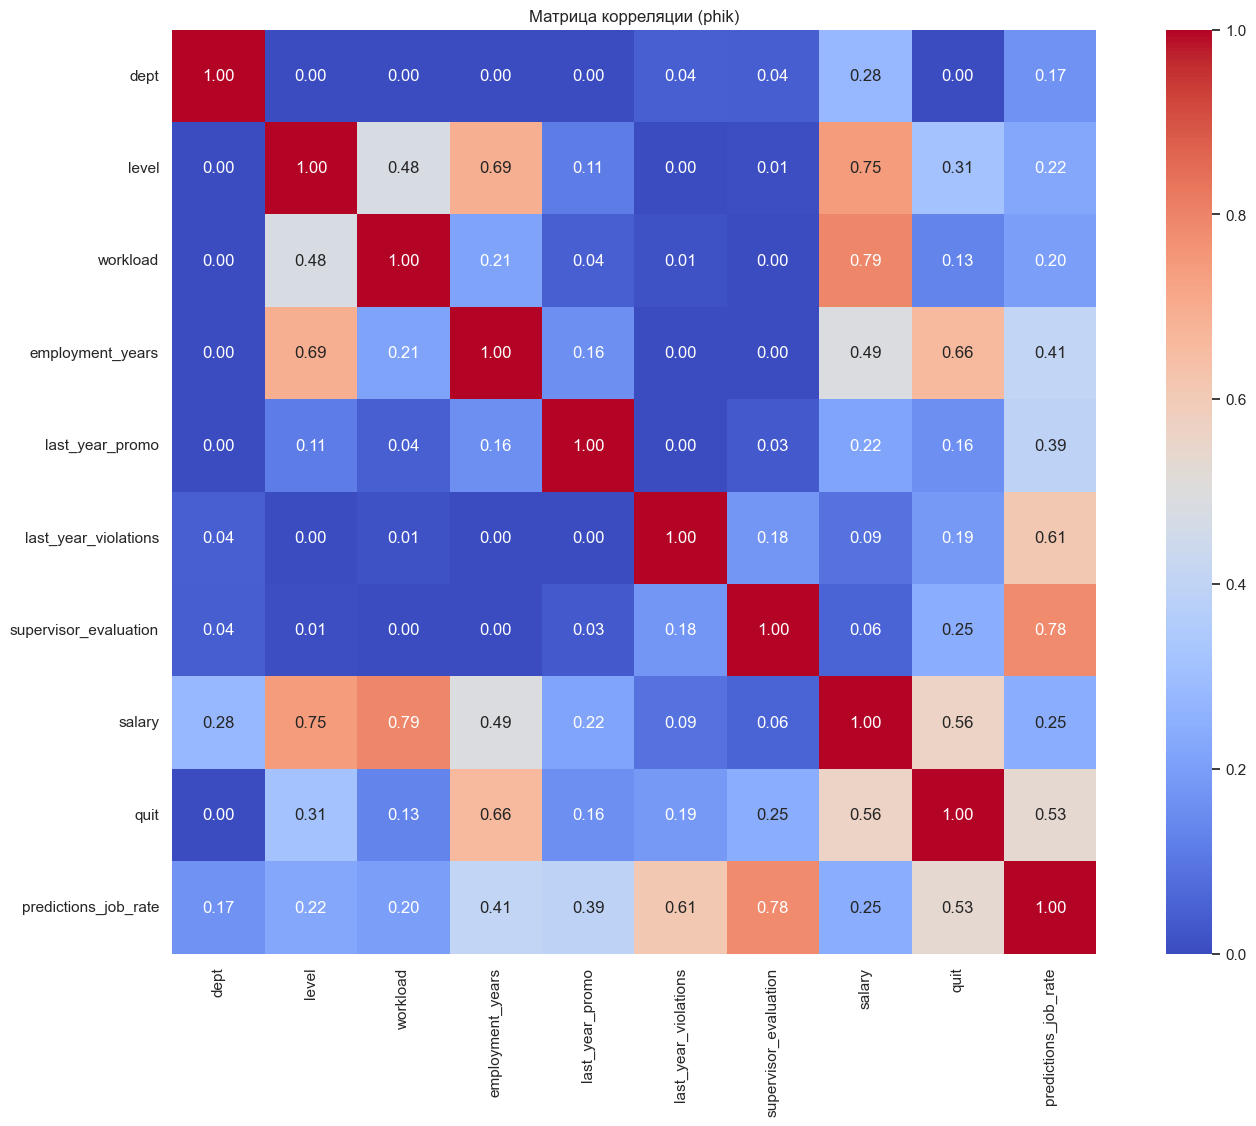

In [61]:
# проведем корреляционный анализ признаков
train_data_quit_cor = train_data_quit.drop(columns=['id'])
correlation_matrix = train_data_quit_cor.phik_matrix()

# визуализируем
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Матрица корреляции (phik)')
plt.show()

# численные данные выбраны верно
# ЗЫ: знаю, что лучше писать руками признаки, но мне так нравится больше + я проверяю, чтобы все было нормально

#### Корреляция

In [62]:
# выведем корреляцию удовлетворенности
corr = correlation_matrix['quit'].sort_values(ascending=False)

display("Сильня корреляция с уровнем удовлетворенности:")
display(corr[corr >= 0.19])

display("Слабая корреляция с уровнем удовлетворенности:")
display(corr[corr < 0.19])

'Сильня корреляция с уровнем удовлетворенности:'

quit                    1.00
employment_years        0.66
salary                  0.56
predictions_job_rate    0.53
level                   0.31
supervisor_evaluation   0.25
Name: quit, dtype: float64

'Слабая корреляция с уровнем удовлетворенности:'

last_year_violations   0.19
last_year_promo        0.16
workload               0.13
dept                   0.00
Name: quit, dtype: float64

#### VIF

In [63]:
get_vif(train_data_quit, 'id', 'quit')

Признаки  VIF
0                   dept 1.01
1                  level 3.35
2               workload 1.10
3       employment_years 2.21
4        last_year_promo 1.07
5   last_year_violations 1.25
6  supervisor_evaluation 2.36
7                 salary 2.28
8   predictions_job_rate 2.98

#### Выводы

Данные выглядят нормально, никакой дополнительной обработки не требуется

## Подготовка данных и обучение

### Подготовка данных

In [64]:
# сделаем таргет 0 / 1

le = LabelEncoder()
train_data_quit['quit'] = le.fit_transform(train_data_quit['quit'])
display(train_data_quit.sample(2))
mapping_array = np.array([(label, index) for index, label in enumerate(le.classes_)], dtype=object)
display(mapping_array)

id        dept   level workload  employment_years last_year_promo  \
3308  987382   marketing  junior   medium                 5              no   
3057  371726  purchasing  middle      low                 4              no   

     last_year_violations  supervisor_evaluation  salary  quit  \
3308                   no                      4   28800     0   
3057                   no                      4   24000     0   

      predictions_job_rate  
3308                  0.75  
3057                  0.69

array([['no', 0],
       ['yes', 1]], dtype=object)

In [65]:
train_data_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   quit                   4000 non-null   int32  
 10  predictions_job_rate   4000 non-null   float64
dtypes: float64(1), int32(1), int64(4), object(5)
memory usage: 328.3+ KB


In [66]:
# разделим на выборки
X_train, X_test, y_train, y_test = train_test_split(
    train_data_quit.drop([
        'quit',
        'id'
    ], axis=1),
    train_data_quit['quit'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = train_data_quit['quit'])

In [67]:
drop_duplicated(X_train)

1325

'Удаляем'

dept   level workload  employment_years last_year_promo  \
0     technology  junior      low                 1              no   
1     purchasing  middle      low                 6              no   
2          sales  middle     high                 4              no   
3     technology  junior   medium                 3              no   
4      marketing  junior   medium                 1              no   
...          ...     ...      ...               ...             ...   
2270   marketing  middle   medium                 2              no   
2271       sales  middle   medium                 4              no   
2272  technology  middle      low                 5              no   
2273  technology  sinior   medium                 7              no   
2274  technology  middle      low                 4              no   

     last_year_violations  supervisor_evaluation  salary  predictions_job_rate  
0                      no                      2   18000                  0.21  
1                      no                      3   24000                  0.49  
2                     yes                      1   50400                  0.10  
3                      no                      3   34800                  0.50  
4                      no                      4   27600                  0.66  
...                   ...                    ...     ...                   ...  
2270                   no                      5   46800                  0.67  
2271                   no                      2   37200                  0.15  
2272                  yes                      4   28800                  0.64  
2273                  yes                      1   60000                  0.26  
2274                  yes                      3   27600                  0.08  

[2275 rows x 9 columns]

In [68]:
X_train.shape, X_test.shape

((3600, 9), (400, 9))

In [69]:
# создаём списки с названиями признаков
# ohe_columns
ohe_columns = get_ohe_columns(X_train)
ohe_columns.append('dept')
# ord_columns.remove('job_satisfaction_rate_bin')
# ohe_columns.append('level')
# ohe_columns.append('workload')

# ord_columns
ord_columns = get_ord_columns(X_train)
ord_columns.remove('dept')
# ord_columns.append('job_satisfaction_rate_bin')

# num_columns
num_columns = get_num_columns(X_train)
# num_columns.remove('id')
# num_columns.remove('salary')
# num_columns.remove('salary_^2')
# num_columns.remove('salary_log')
# num_columns.remove('salary_segm')

# num_columns.remove('employment_years')
# num_columns.remove('employment_years_^2')

# num_columns.remove('supervisor_evaluation')
# num_columns.remove('supervisor_evaluation_^2')

# num_columns.remove('predictions_job_rate')
# num_columns.remove('predictions_job_rate_^2')


# ohe (dept) и ord (level, workload);

In [70]:
display("Признаки для OHE:", ohe_columns)
display("Признаки для Ordinal:", ord_columns)
display("Количественные признаки:", num_columns)

'Признаки для OHE:'

['last_year_promo', 'last_year_violations', 'dept']

'Признаки для Ordinal:'

['level', 'workload']

'Количественные признаки:'

['employment_years', 'supervisor_evaluation', 'salary', 'predictions_job_rate']

### Подготовка пайплайна

In [71]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
# пока оставим most_frequent, возможно потом пересмотрим это решение
binary_columns = ['last_year_promo', 'last_year_violations']
dept_column = ['dept']

ohe_pipe = ColumnTransformer(
    transformers=[
        ('binary', Pipeline(steps=[
            ('replace_empty', ReplaceEmptyWithNaN()),
            ('simpleImputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
        ]), binary_columns),

        ('dept', Pipeline(steps=[
            ('replace_empty', ReplaceEmptyWithNaN()),
            ('simpleImputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), dept_column)
    ]
)

In [72]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [
        ('replace_empty', ReplaceEmptyWithNaN()),
        ('simpleImputer_before_ord', SimpleImputer(strategy='most_frequent')),
        ('ord', OrdinalEncoder(
            categories=[
                ['junior', 'middle', 'senior'],
                ['low', 'medium', 'high']
            ], 
            handle_unknown='use_encoded_value', unknown_value=np.nan
        )),
        ('simpleImputer_after_ord', SimpleImputer(strategy='most_frequent'))
    ]
)

In [73]:
minmax_pipeline = Pipeline(steps=[
    ('simpleImputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

standard_pipeline = Pipeline(steps=[
    ('simpleImputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

robust_pipeline = Pipeline(steps=[
    ('simpleImputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

# Объединение пайплайнов в ColumnTransformer
num_pipeline = ColumnTransformer(
    transformers=[
        ('minmax', minmax_pipeline, num_columns),
        ('standard', standard_pipeline, num_columns),
        ('robust', robust_pipeline, num_columns)
    ]
)

### Обучение модели

In [74]:
# здесь у нас уже классификация и метрика roc-auc
optuna.logging.set_verbosity(optuna.logging.ERROR)

result = []
used_params = set()

def objective(trial):
    model_choice = trial.suggest_categorical('model', ['DecisionTree', 'KNeighbors', 'LogisticRegression', 'RandomForest'])
    scaler_choice = trial.suggest_categorical('scaler', ['MinMaxScaler', 'StandardScaler', 'RobustScaler'])
    k_features = trial.suggest_int('k_features', 1, X_train.shape[1])
    
    params_tuple = None

    if model_choice == 'DecisionTree':
        max_depth = trial.suggest_int('max_depth', 2, 100)
        max_features = trial.suggest_int('max_features', 2, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
        params_tuple = (model_choice, max_depth, max_features, min_samples_split)

    elif model_choice == 'KNeighbors':
        n_neighbors = trial.suggest_int('n_neighbors', 2, 100)
        params_tuple = (model_choice, n_neighbors)

    elif model_choice == 'LogisticRegression':
        C = trial.suggest_float('C', 0.01, 1000.0, log=True)
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
        params_tuple = (model_choice, C, penalty)

    elif model_choice == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        max_depth = trial.suggest_int('max_depth', 2, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
        params_tuple = (model_choice, n_estimators, max_depth, min_samples_split)

    if params_tuple in used_params:
        return 0
    used_params.add(params_tuple)

    # создаем модель
    if model_choice == 'DecisionTree':
        model = DecisionTreeClassifier(max_depth=max_depth,
                                       max_features=max_features, 
                                       min_samples_split=min_samples_split,
                                       random_state=RANDOM_STATE,
                                       class_weight=CLASS_WEIGHT)
    
    elif model_choice == 'KNeighbors':
        model = KNeighborsClassifier(n_neighbors=n_neighbors,
                                     weights=WEIGHTS_FOR_KNEIGHBORS)
    
    elif model_choice == 'LogisticRegression':
        model = LogisticRegression(C=C,
                                   random_state=RANDOM_STATE,
                                   solver='liblinear',
                                   penalty=penalty,
                                   class_weight=CLASS_WEIGHT)

    elif model_choice == 'RandomForest':
        model = RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       random_state=RANDOM_STATE,
                                       class_weight=CLASS_WEIGHT)

    # создаем пайплайн для числовых данных
    if scaler_choice == 'MinMaxScaler':
        num_pipeline = Pipeline(steps=[
            ('simpleImputer', SimpleImputer(strategy='mean')),
            ('scaler', MinMaxScaler())
        ])
    elif scaler_choice == 'StandardScaler':
        num_pipeline = Pipeline(steps=[
            ('simpleImputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])
    else:
        num_pipeline = Pipeline(steps=[
            ('simpleImputer', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler())
        ])
        
    data_preprocessor = ColumnTransformer(
        [('ohe', ohe_pipe, ohe_columns),
         ('ord', ord_pipe, ord_columns),
         ('num', num_pipeline, num_columns)
        ], 
        remainder='passthrough'
    )

    pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('feature_selection', SelectKBest(score_func=f_classif, k=k_features)),
        ('models', model)
    ])
    
    # roc_auc в качестве метрики
    scoring_metric = 'roc_auc'
    scores = cross_val_score(pipe_final, X_train, y_train, cv=5, scoring=scoring_metric)
    mean_score = scores.mean()
    
    pipe_final.fit(X_train, y_train)
    y_pred = pipe_final.predict(X_test)
    
    test_score = roc_auc_score(y_test, y_pred)

    result.append({
        'model': model_choice,
        'scaler': scaler_choice,
        'k_features': k_features,
        'max_depth': trial.params.get('max_depth', None),
        'max_features': trial.params.get('max_features', None),
        'min_samples_split': trial.params.get('min_samples_split', None),
        'n_neighbors': trial.params.get('n_neighbors', None),
        'C': trial.params.get('C', None),
        'n_estimators': trial.params.get('n_estimators', None),
        'scoring_metric_train': mean_score,
        'scoring_metric_train_test': test_score,
        'pipeline': pipe_final,
    })

    return mean_score

study = optuna.create_study(direction='maximize')

for _ in tqdm(range(N), desc="Trials"):
    study.optimize(objective, n_trials=N)

best_index = max(range(len(result)), key=lambda i: result[i]['scoring_metric_train_test'])  # изменено на max
best_metrics = result[best_index]
best_params = best_metrics.copy()

final_output = {**best_params}

Trials: 100%|██████████████████████████████████████████████████████████████████████████| 15/15 [02:50<00:00, 11.34s/it]


### Лучшая модель

In [75]:
best_params_df = pd.DataFrame(list(final_output.items()), columns=['Параметры', 'Значение'])
display(format_display("Лучшая модель и параметры на тренировочных данных"))
filtered_df = best_params_df[best_params_df['Значение'].notna()]
display(filtered_df)

Параметры  \
0                       model   
1                      scaler   
2                  k_features   
3                   max_depth   
5           min_samples_split   
8                n_estimators   
9        scoring_metric_train   
10  scoring_metric_train_test   
11                   pipeline   

                                             Значение  
0                                        RandomForest  
1                                      StandardScaler  
2                                                   9  
3                                                  71  
5                                                  18  
8                                                 102  
9                                                0.94  
10                                               0.90  
11  (ColumnTransformer(remainder='passthrough',\n ...

In [76]:
result_df_2 = pd.DataFrame(result)
result_df_2 = result_df_2.sort_values(by=['scoring_metric_train_test'], ascending=False)
display(result_df_2.head(5))
display(result_df_2.info())

model          scaler  k_features  max_depth  max_features  \
159  RandomForest  StandardScaler           9      71.00           NaN   
75   RandomForest  StandardScaler           9      44.00           NaN   
52   RandomForest  StandardScaler           8      34.00           NaN   
26   RandomForest  StandardScaler           9      16.00           NaN   
218  RandomForest  StandardScaler           8      55.00           NaN   

     min_samples_split  n_neighbors   C  n_estimators  scoring_metric_train  \
159              18.00          NaN NaN        102.00                  0.94   
75               18.00          NaN NaN         91.00                  0.94   
52               30.00          NaN NaN         83.00                  0.94   
26                5.00          NaN NaN         75.00                  0.93   
218              24.00          NaN NaN        111.00                  0.94   

     scoring_metric_train_test  \
159                       0.90   
75                        0.90   
52                        0.90   
26                        0.90   
218                       0.90   

                                              pipeline  
159  (ColumnTransformer(remainder='passthrough',\n ...  
75   (ColumnTransformer(remainder='passthrough',\n ...  
52   (ColumnTransformer(remainder='passthrough',\n ...  
26   (ColumnTransformer(remainder='passthrough',\n ...  
218  (ColumnTransformer(remainder='passthrough',\n ...

<class 'pandas.core.frame.DataFrame'>
Index: 224 entries, 159 to 88
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   model                      224 non-null    object 
 1   scaler                     224 non-null    object 
 2   k_features                 224 non-null    int64  
 3   max_depth                  200 non-null    float64
 4   max_features               15 non-null     float64
 5   min_samples_split          200 non-null    float64
 6   n_neighbors                12 non-null     float64
 7   C                          12 non-null     float64
 8   n_estimators               185 non-null    float64
 9   scoring_metric_train       224 non-null    float64
 10  scoring_metric_train_test  224 non-null    float64
 11  pipeline                   224 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 22.8+ KB


None

In [77]:
display(format_display('Лучшая модель, ее настройки и параметры'))
best_model = best_metrics['pipeline']
display(best_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  ColumnTransformer(transformers=[('binary',
                                                                                   Pipeline(steps=[('replace_empty',
                                                                                                    ReplaceEmptyWithNaN()),
                                                                                                   ('simpleImputer',
                                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                                   ('ohe',
                                                                                                    OneHotEncoder(drop='if_binary',
                                                                                                                  handle_unknown='ignore'))]),
                                                                                   ['last_year_promo',
                                                                                    'last_year_vio...
                                                  ['level', 'workload']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleImputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary',
                                                   'predictions_job_rate'])])),
                ('feature_selection', SelectKBest(k=9)),
                ('models',
                 RandomForestClassifier(class_weight='balanced', max_depth=71,
                                        min_samples_split=18, n_estimators=102,
                                        random_state=20))])

In [78]:
# получаем признаки, какие были отобраны для лучшей модели и по ним построим график важности признаков SHAP
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

select_k_best = best_model.named_steps['feature_selection']
selected_indices = select_k_best.get_support(indices=True)
selected_feature_names = feature_names[selected_indices]

X_train_new = pd.DataFrame(X_train_transformed, columns=feature_names)
X_train_new = X_train_new[selected_feature_names]

model = best_model.named_steps['models']
model_name = model.__class__.__name__

K = 100
background_data = shap.sample(X_train_new, K)

X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)
X_test_new = pd.DataFrame(X_test_transformed, columns=feature_names)[selected_feature_names]

if isinstance(model, (SVC, KNeighborsClassifier, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier)):
    if isinstance(model, SVC):
        explainer = shap.KernelExplainer(model.decision_function, background_data)
        shap_values = explainer.shap_values(X_test_new, n_jobs=-1)
    elif isinstance(model, KNeighborsClassifier):
        explainer = shap.KernelExplainer(model.predict_proba, background_data)
        shap_values = explainer.shap_values(X_test_new)
    elif isinstance(model, LogisticRegression):
        explainer = shap.LinearExplainer(model, background_data)
        shap_values = explainer.shap_values(X_test_new)
    elif isinstance(model, DecisionTreeClassifier):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test_new)
    elif isinstance(model, RandomForestClassifier):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test_new)

In [79]:
display(X_test_new.shape)
display(shap_values.shape)
if X_test_new.shape != shap_values.shape:
    shap_values = shap_values[:, :, 1]

(400, 9)

(400, 9, 2)

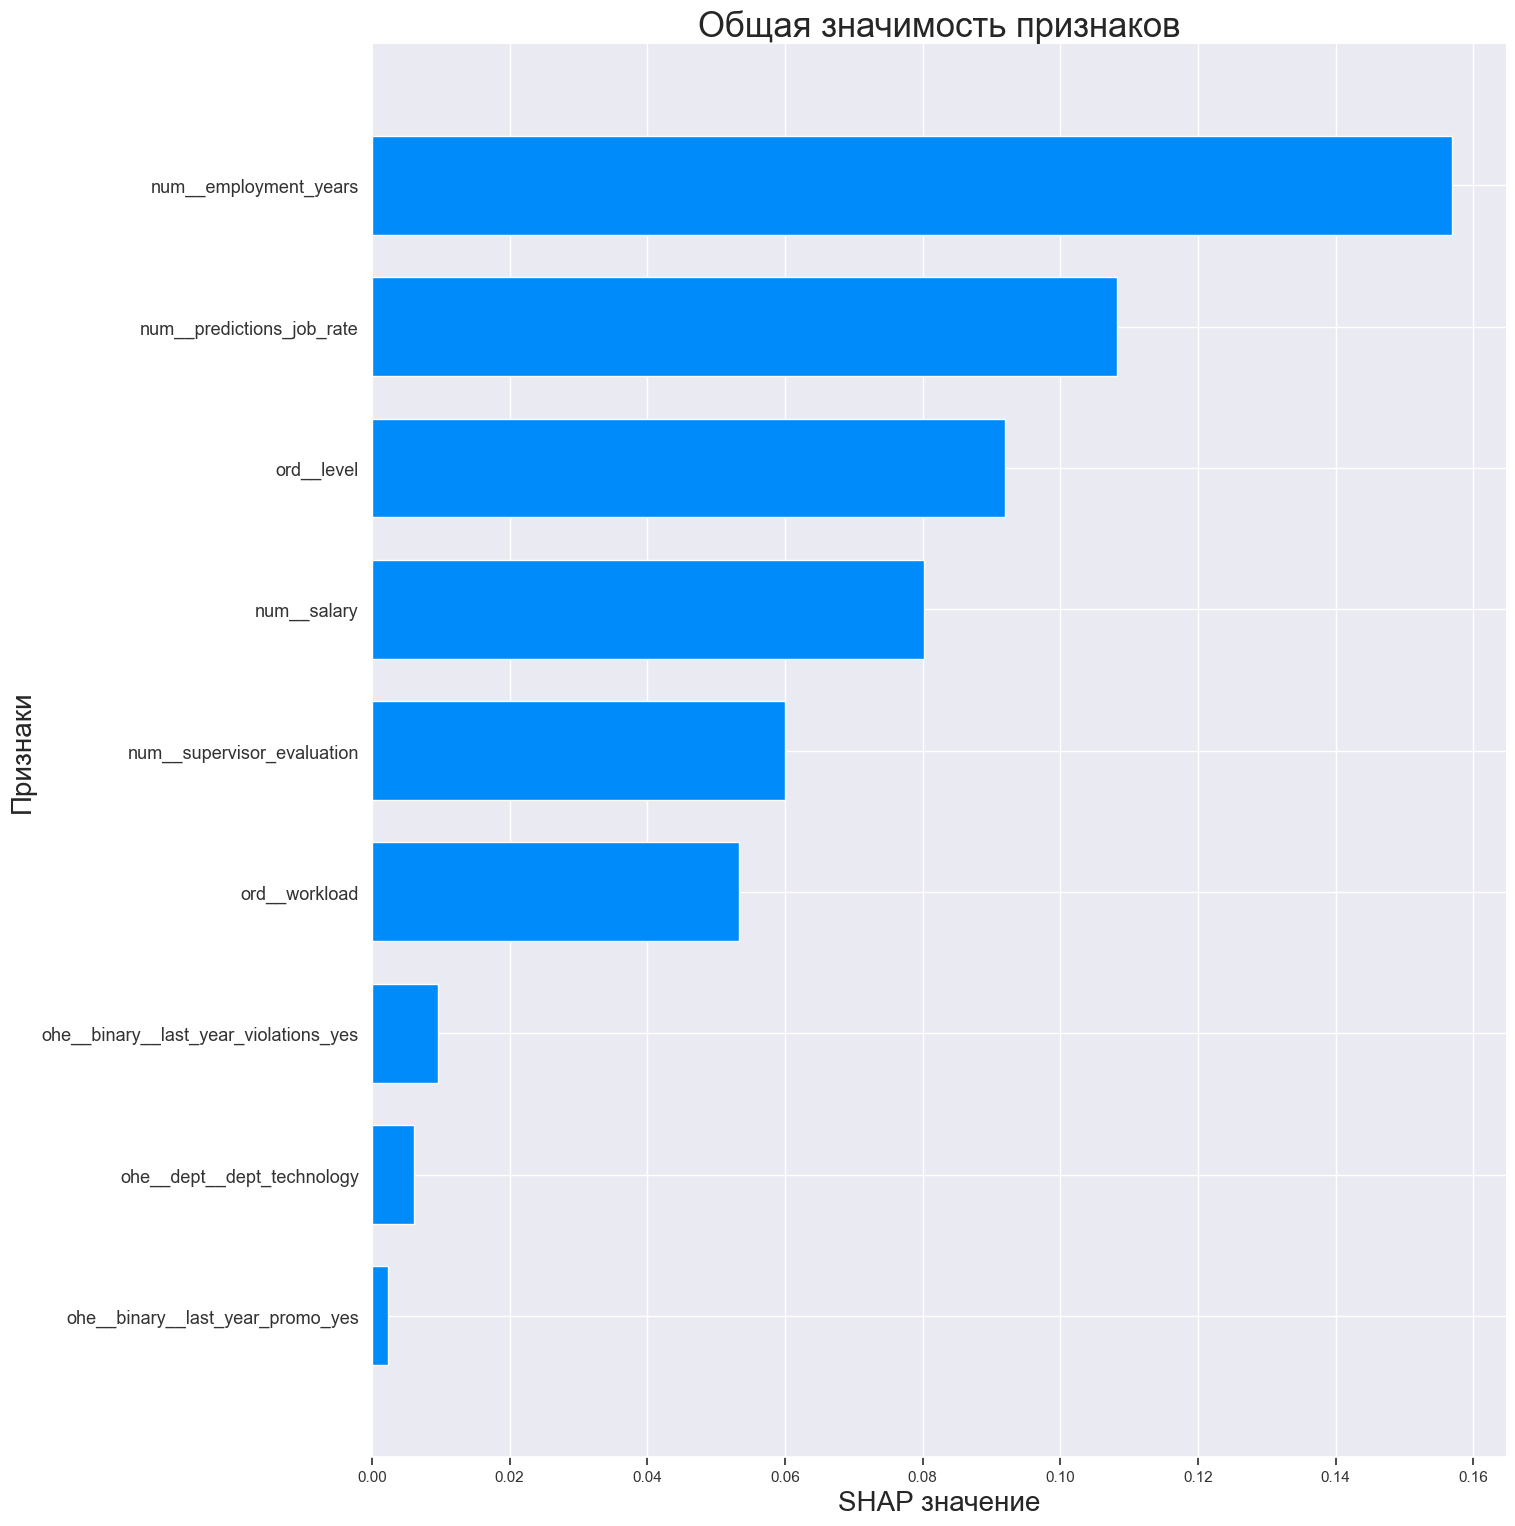

In [80]:
# первый график
shap.summary_plot(
    shap_values, 
    X_test_new, 
    plot_type="bar",
    max_display=30, 
    plot_size=(15, 15),
    show=False
)

plt.title('Общая значимость признаков', fontsize=25)
plt.xlabel('SHAP значение', fontsize=20)
plt.ylabel('Признаки', fontsize=20)
plt.show()

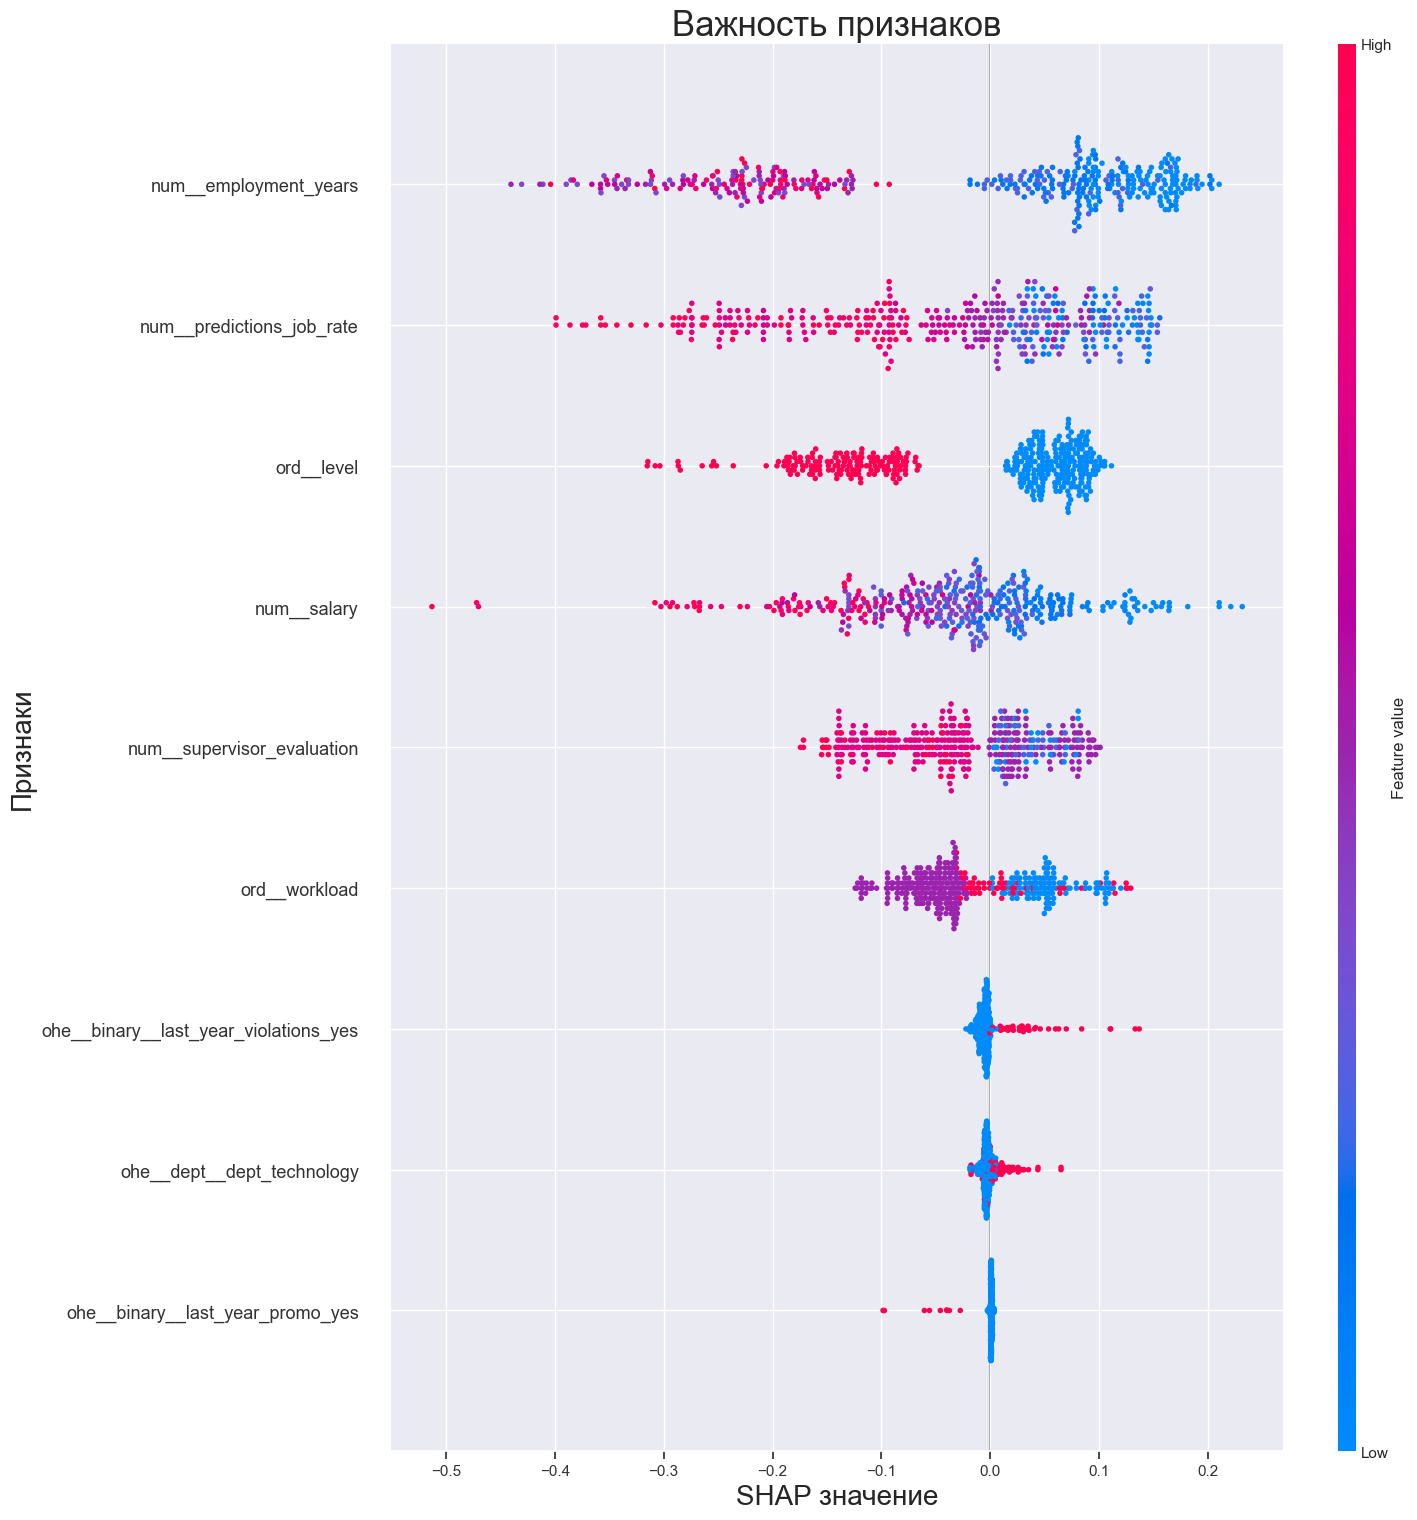

In [81]:
# второй график
shap.summary_plot(
    shap_values, 
    X_test_new, 
    plot_type="dot", 
    max_display=30, 
    plot_size=(15, 15),
    show=False
)

plt.title('Важность признаков', fontsize=25)
plt.xlabel('SHAP значение', fontsize=20)
plt.ylabel('Признаки', fontsize=20)
plt.show()

Итак, исходя из построенных графиков можем сделать следующие выводы:  
1) Для модели наиболее значимым являются такие признаки как грейд, удовлетворенность, стаж и загруженность;  
2) Все эти признаки, при их росте, влияют на то, что сотрудник останется в компании;  
3) И, что интересно - если растет доход, то значит будет увольнение, пусть и незначительый показатель, но он есть...

### Предсказание на тестовых данных

In [82]:
# здесь получаем признаки на каких было обучение лучшей модели и используем их же на предсказание в тестовых данных
X_test_transformed = best_model.named_steps['preprocessor'].transform(features_test_data)
feature_names_transformed = best_model.named_steps['preprocessor'].get_feature_names_out()
features_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names_transformed)

select_k_best = best_model.named_steps['feature_selection']
selected_indices = select_k_best.get_support(indices=True)
selected_feature_names = feature_names_transformed[selected_indices]

filtered_test_data = features_test_transformed_df[selected_feature_names]
features_test_data['quit_predictions'] = best_model.named_steps['models'].predict_proba(filtered_test_data)[:, 1]

features_test_data = merge_base([features_test_data, test_target_quit_data], 'id', 'inner')
features_test_data['quit_bin'] = np.where(features_test_data['quit'] == 'yes', 1, 0)
display(features_test_data)

D:\anaconda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



id        dept   level workload  employment_years last_year_promo  \
0     485046   marketing  junior   medium                 2              no   
1     686555          hr  junior   medium                 1              no   
2     467458       sales  middle      low                 5              no   
3     418655       sales  middle      low                 6              no   
4     789145          hr  middle   medium                 5              no   
...      ...         ...     ...      ...               ...             ...   
1995  393147   marketing  junior      low                 3              no   
1996  109582  technology  middle      low                 3              no   
1997  305653  technology  junior      low                 1              no   
1998  160233  technology  middle      low                 8              no   
1999  771859  purchasing  middle   medium                 1              no   

     last_year_violations  supervisor_evaluation  salary  \
0                      no                      5   28800   
1                      no                      4   30000   
2                      no                      4   19200   
3                      no                      4   19200   
4                      no                      5   40800   
...                   ...                    ...     ...   
1995                   no                      3   20400   
1996                   no                      2   21600   
1997                   no                      3   14400   
1998                   no                      1   32400   
1999                   no                      4   38400   

      predictions_job_rate  job_satisfaction_rate job_satisfaction_rate_bin  \
0                     0.88                   0.79                   доволен   
1                     0.67                   0.72                   доволен   
2                     0.66                   0.64                   доволен   
3                     0.66                   0.60                   доволен   
4                     0.83                   0.75                   доволен   
...                    ...                    ...                       ...   
1995                  0.52                   0.56                 недоволен   
1996                  0.17                   0.14                 недоволен   
1997                  0.16                   0.11                 недоволен   
1998                  0.43                   0.43                 недоволен   
1999                  0.57                   0.67                   доволен   

      quit_predictions quit  quit_bin  
0                 0.36   no         0  
1                 0.33   no         0  
2                 0.26   no         0  
3                 0.12   no         0  
4                 0.05   no         0  
...                ...  ...       ...  
1995              0.93  yes         1  
1996              0.91  yes         1  
1997              0.99  yes         1  
1998              0.14   no         0  
1999              0.19   no         0  

[2000 rows x 15 columns]

Построим матрицу ошибок и посмотрим насколько верно мы предсказали события.

D:\anaconda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



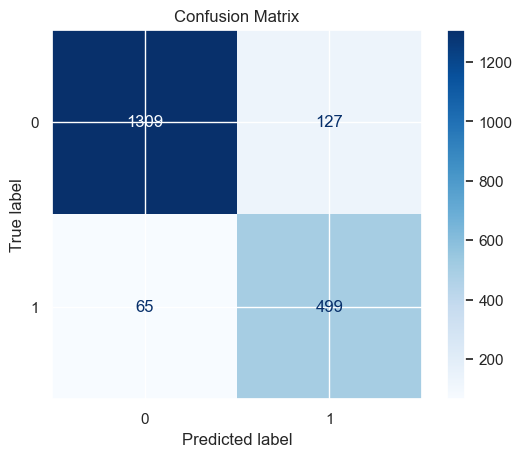

In [83]:
predictions = best_model.named_steps['models'].predict(filtered_test_data)
cm = confusion_matrix(features_test_data['quit_bin'], predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Попробуем улучшить показатели и подберем пороги для того, чтобы TN и FP стремились к нулю

D:\anaconda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



'Оптимальный порог для достижения оптимальных предсказаний: 0.69'

'Оптимальным считается:'

'снижение (TN, 01) предсказано, что остались, но они ушли - максимальный приоритет'

'снижение (FP, 10) предсказано, что ушли, но они остались - второй приоритет'

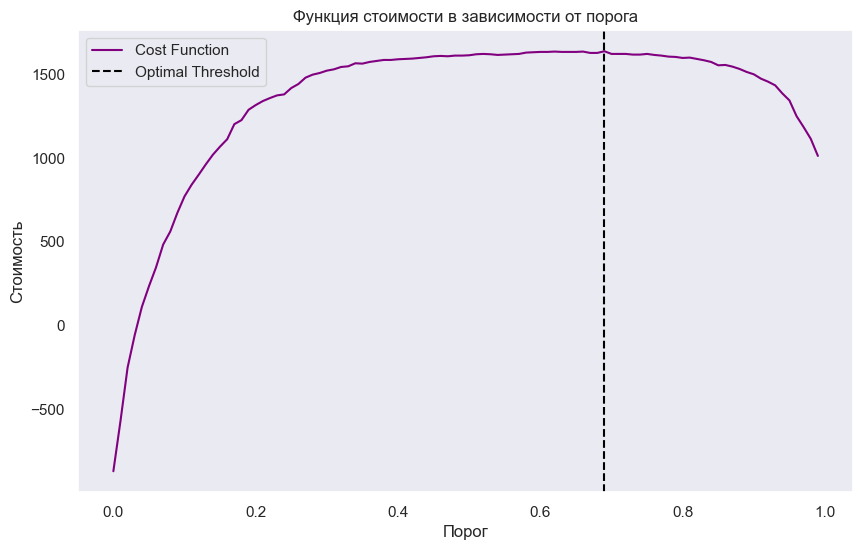

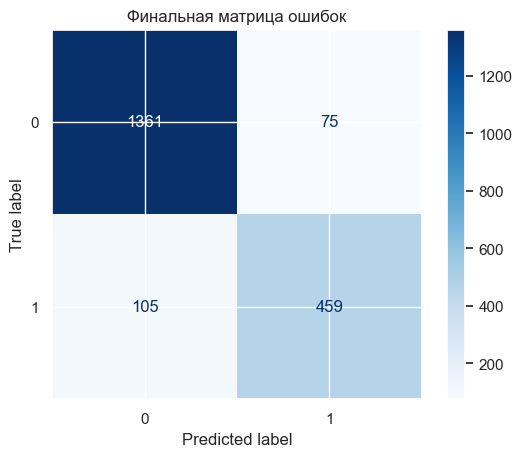

In [84]:
probabilities = best_model.named_steps['models'].predict_proba(filtered_test_data)[:, 1]
thresholds = np.arange(0.0, 1.0, 0.01)

costs = []

for threshold in thresholds:
    predictions = (probabilities >= threshold).astype(int)
    cm = confusion_matrix(features_test_data['quit_bin'], predictions)
    
    tn, fp, fn, tp = cm.ravel()
    
    # Определяем "стоимость" на основе ваших требований
    # Например, можно использовать веса:
    cost = (1 * tn) - (1 * fp) - (1 * fn) + (1 * tp)
    costs.append(cost)

# Находим порог, при котором "стоимость" максимальна
optimal_threshold_index = np.argmax(costs)
optimal_threshold = thresholds[optimal_threshold_index]

display(f'Оптимальный порог для достижения оптимальных предсказаний: {optimal_threshold:.2f}')
display(f'Оптимальным считается:')
display(f'снижение (TN, 01) предсказано, что остались, но они ушли - максимальный приоритет')
display(f'снижение (FP, 10) предсказано, что ушли, но они остались - второй приоритет')

# Визуализируем "стоимость" в зависимости от порога
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, label='Cost Function', color='purple')
plt.axvline(optimal_threshold, linestyle='--', color='black', label='Optimal Threshold')
plt.title('Функция стоимости в зависимости от порога')
plt.xlabel('Порог')
plt.ylabel('Стоимость')
plt.legend()
plt.grid()
plt.show()

# Используем оптимальный порог для финальных предсказаний
final_predictions = (probabilities >= optimal_threshold).astype(int)

# Создаем финальную матрицу ошибок
final_cm = confusion_matrix(features_test_data['quit_bin'], final_predictions)

# Визуализируем финальную матрицу ошибок
final_disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=['0', '1'])
final_disp.plot(cmap=plt.cm.Blues)
plt.title('Финальная матрица ошибок')
plt.show()

In [85]:
# 00 - должно стремиться к максимум
# 01 - должно стремится к минимуму
# 10 - должно стремится к минимуму
# 11 - должно стремится к максимуму

441 - (TP, 11) верно предсказаны, что ушли  
86 - (TN, 01) предсказано, что остались, но они ушли  
1350 - (FN, 00) верно предсказано, что остались  
123 - (FP, 10) предсказано, что ушли, но они остались  

Для нас важно, что мы ошиблись в TN случаях, т.к. люди все таки ушли и теперь надо открывать найм новых, тратить на это ресурсы и средства, а ведь могли бы и удержать, если для бизнеса было бы это важно.  
И важно, что FP не ушло, а мы потратили на них лишние ресурсы пытаясь удержать, хоть этого и не трбовалось.  
НО! затраты на FP значительно ниже чем TN, т.к. можно было бы просто сесть и поговорить и все решить, а вот с упущенными ушедшими только новый найм  
Как следствие, надо надо стараться при обучении в первую очередь опускать TN, потом уже FP, а другие параметры стремится повышать, для повышения качества модели.

In [86]:
display(features_test_data)

id        dept   level workload  employment_years last_year_promo  \
0     485046   marketing  junior   medium                 2              no   
1     686555          hr  junior   medium                 1              no   
2     467458       sales  middle      low                 5              no   
3     418655       sales  middle      low                 6              no   
4     789145          hr  middle   medium                 5              no   
...      ...         ...     ...      ...               ...             ...   
1995  393147   marketing  junior      low                 3              no   
1996  109582  technology  middle      low                 3              no   
1997  305653  technology  junior      low                 1              no   
1998  160233  technology  middle      low                 8              no   
1999  771859  purchasing  middle   medium                 1              no   

     last_year_violations  supervisor_evaluation  salary  \
0                      no                      5   28800   
1                      no                      4   30000   
2                      no                      4   19200   
3                      no                      4   19200   
4                      no                      5   40800   
...                   ...                    ...     ...   
1995                   no                      3   20400   
1996                   no                      2   21600   
1997                   no                      3   14400   
1998                   no                      1   32400   
1999                   no                      4   38400   

      predictions_job_rate  job_satisfaction_rate job_satisfaction_rate_bin  \
0                     0.88                   0.79                   доволен   
1                     0.67                   0.72                   доволен   
2                     0.66                   0.64                   доволен   
3                     0.66                   0.60                   доволен   
4                     0.83                   0.75                   доволен   
...                    ...                    ...                       ...   
1995                  0.52                   0.56                 недоволен   
1996                  0.17                   0.14                 недоволен   
1997                  0.16                   0.11                 недоволен   
1998                  0.43                   0.43                 недоволен   
1999                  0.57                   0.67                   доволен   

      quit_predictions quit  quit_bin  
0                 0.36   no         0  
1                 0.33   no         0  
2                 0.26   no         0  
3                 0.12   no         0  
4                 0.05   no         0  
...                ...  ...       ...  
1995              0.93  yes         1  
1996              0.91  yes         1  
1997              0.99  yes         1  
1998              0.14   no         0  
1999              0.19   no         0  

[2000 rows x 15 columns]

Перепредскажем уходы

In [87]:
threshold = optimal_threshold
probabilities = best_model.named_steps['models'].predict_proba(filtered_test_data)[:, 1]
features_test_data['quit_cm'] = np.where(probabilities >= threshold, 'yes', 'no')
features_test_data['quit_bin_cm'] = (probabilities >= threshold).astype(int)
features_test_data['quit_bin_cm'] = np.where(features_test_data['quit_cm'] == 'yes', 1, 0)

display(features_test_data)

D:\anaconda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



id        dept   level workload  employment_years last_year_promo  \
0     485046   marketing  junior   medium                 2              no   
1     686555          hr  junior   medium                 1              no   
2     467458       sales  middle      low                 5              no   
3     418655       sales  middle      low                 6              no   
4     789145          hr  middle   medium                 5              no   
...      ...         ...     ...      ...               ...             ...   
1995  393147   marketing  junior      low                 3              no   
1996  109582  technology  middle      low                 3              no   
1997  305653  technology  junior      low                 1              no   
1998  160233  technology  middle      low                 8              no   
1999  771859  purchasing  middle   medium                 1              no   

     last_year_violations  supervisor_evaluation  salary  \
0                      no                      5   28800   
1                      no                      4   30000   
2                      no                      4   19200   
3                      no                      4   19200   
4                      no                      5   40800   
...                   ...                    ...     ...   
1995                   no                      3   20400   
1996                   no                      2   21600   
1997                   no                      3   14400   
1998                   no                      1   32400   
1999                   no                      4   38400   

      predictions_job_rate  job_satisfaction_rate job_satisfaction_rate_bin  \
0                     0.88                   0.79                   доволен   
1                     0.67                   0.72                   доволен   
2                     0.66                   0.64                   доволен   
3                     0.66                   0.60                   доволен   
4                     0.83                   0.75                   доволен   
...                    ...                    ...                       ...   
1995                  0.52                   0.56                 недоволен   
1996                  0.17                   0.14                 недоволен   
1997                  0.16                   0.11                 недоволен   
1998                  0.43                   0.43                 недоволен   
1999                  0.57                   0.67                   доволен   

      quit_predictions quit  quit_bin quit_cm  quit_bin_cm  
0                 0.36   no         0      no            0  
1                 0.33   no         0      no            0  
2                 0.26   no         0      no            0  
3                 0.12   no         0      no            0  
4                 0.05   no         0      no            0  
...                ...  ...       ...     ...          ...  
1995              0.93  yes         1     yes            1  
1996              0.91  yes         1     yes            1  
1997              0.99  yes         1     yes            1  
1998              0.14   no         0      no            0  
1999              0.19   no         0      no            0  

[2000 rows x 17 columns]

In [88]:
test_score = roc_auc_score(features_test_data['quit_bin_cm'], features_test_data['quit_predictions'])
display(format_display('Результат метрики roc-auc на тестовой таблице'))
display(round(test_score, 2))

1.0

По ТЗ должно быть >= 0.91  
А здесь 1.0 и это пугает...

D:\anaconda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



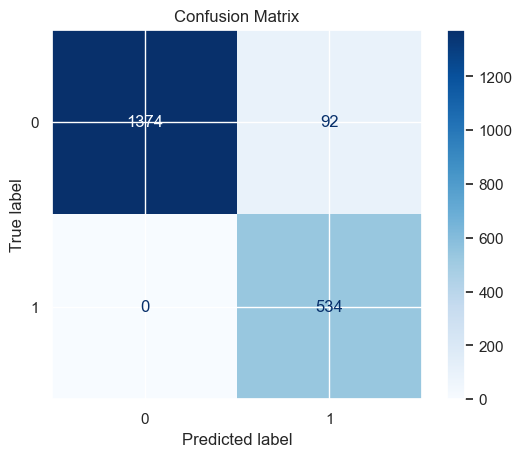

In [89]:
predictions = best_model.named_steps['models'].predict(filtered_test_data)
cm = confusion_matrix(features_test_data['quit_bin_cm'], predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Но и правда, получилось достигнуть того, что мы теперь точно знаем, что у нас не будет тех кто увольняется, но модель бы сказала, что нет

### Выводы

С помощью метода Optuna была подобрана оптимальная модель с гиперпараметрами среди 'DecisionTree', 'KNeighbors', 'LogisticRegression', 'SVC'.  
Также в этой задаче для достижения требуемой оценки был добавлен этап отбора наиболее важных признаков для модели, а неважные были отброшены, что позволило разгрузить модель.  

На тренировочных данных показатели получились следующие:  

	Параметры	Значение  
0	model	DecisionTree  
1	scaler	MinMaxScaler  
2	k_features	6  
3	max_depth	72  
4	max_features	5  
5	min_samples_split	86  
10	scoring_metric_train	0.92  
11	scoring_metric_train_test	0.89  
  

На мой взгляд, у DecisionTree больше вариаций для подбора оптимального решения, быстро обучается на больших данных, а правильная настройка позволяет избегать переобучения - поэтому она и справилась лучше остальных.

С помощью лучшей модели были обработаны тестовые данные и получены предсказания.  
Метрика roc-auc выдала значение - 1.0, что подходит под требования ТЗ, хоть и выглядяит слишком идеальным...    

## Общий вывод

Описание задачи  
Проект направлен на анализ данных сотрудников компании «Работа с заботой» с целью предсказания уровня удовлетворенности сотрудников и вероятности их увольнения. Уровень удовлетворенности напрямую влияет на текучесть кадров, что может привести к финансовым потерям для компании. Задачи включают построение моделей для предсказания как уровня удовлетворенности, так и вероятности увольнения.  

Этапы работы  

Загрузка данных:  
Загрузка тренировочных и тестовых выборок для обеих задач.  

Предобработка данных:  
Изучение данных на наличие пропусков и аномалий.  
Заполнение пропусков: категориальные — модой, числовые — средними значениями.  

Исследовательский анализ данных:  
Анализ признаков, выявление корреляций.  
Определение факторов, влияющих на уровень удовлетворенности и увольнения.  

Подготовка данных:  
Создание пайплайна для обработки данных, включая кодирование категориальных признаков (One-Hot и Ordinal Encoding) и стандартизацию числовых данных (MinMaxScaler, StandardScaler, RobustScaler).  

Обучение моделей:  
Для первой задачи использованы модели Decision Tree и Linear Regression. Подбор гиперпараметров с помощью Optuna.  
Для второй задачи использованы модели Decision Tree, KNeighbors, Logistic Regression, с учетом важности признаков.  

Оценка качества моделей:  
Для первой задачи метрика SMAPE достигла значения 14.23, что соответствует требованиям.  
Для второй задачи метрика ROC-AUC составила 1.0, что также соответствует критериям успеха.  

Выводы:  
Определены ключевые факторы недовольства: стаж работы, оценки от руководства, отсутствие повышения зарплаты.  
Выявлено, что типичный увольняющийся сотрудник — молодой специалист с небольшим стажем, работающий в отделе продаж, с доходом до 40,000.  

Выводы и рекомендации для бизнеса  
Улучшение условий труда: Рекомендуется повысить зарплаты и улучшить условия работы, особенно для сотрудников с низкой удовлетворенностью.  
Систематический мониторинг: Регулярные опросы удовлетворенности помогут выявлять проблемы до того, как они приведут к увольнениям.  
Карьерный рост: Внедрение программ повышения квалификации и карьерного роста может снизить текучесть кадров.  
Анализ данных: Продолжение использования аналитики для выявления факторов, влияющих на удовлетворенность и текучесть, поможет компании принимать более обоснованные решения.  
Таким образом, проект подтвердил важность анализа данных для оптимизации управления персоналом и снижения текучести кадров.